In [1]:
import gc
import pathlib
from typing import Dict, List, Tuple, Union
import sys

from joblib import load
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.preprocessing import OrdinalEncoder

sys.path.append('..')

from scripts.evaluate import Evaluator
from scripts.get_depth_paths import get_depth_paths
from scripts.get_logger import get_logger
from scripts.merge_dataset import merge_dataset

gc.enable()
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 100)

In [2]:
pl.__version__

'0.20.15'

In [3]:
class PathHandler:
    competition_dir = pathlib.Path('../../inputs')
    parquet_files_dir = competition_dir.joinpath('parquet_files')
    feature_dir = pathlib.Path('../../outputs/features')
    model_dir = sorted([p for p in pathlib.Path('../../outputs').glob('model_outputs*')])[-1]


paths = PathHandler()

- P - Transform DPD (Days past due)
- M - Masking categories
- A - Transform amount
- D - Transform date
- T - Unspecified Transform
- L - Unspecified Transform

In [4]:
bool_features = pd.read_csv(paths.feature_dir.joinpath('bool_features.csv'))
float64_features = pd.read_csv(paths.feature_dir.joinpath('float64_features.csv'))
string_features = pd.read_csv(paths.feature_dir.joinpath('string_features.csv'))
date_features = pd.read_csv(paths.feature_dir.joinpath('date_features.csv'))

bool_features['cast_dtype'] = pl.Boolean
float64_features['cast_dtype'] = pl.Float32
string_features['cast_dtype'] = pl.String
date_features['cast_dtype'] = pl.Date

cast_features = pd.concat([bool_features, float64_features, string_features])
display(cast_features)

Variable  \
0              remitter_829L   
1   contaddr_matchlist_1032L   
2         isbidproduct_1095L   
3           isdebitcard_729L   
4   contaddr_smempladdr_334L   
..                       ...   
94          addres_role_871L   
95    cacccardblochreas_147M   
96  relatedpersons_role_762T   
97        riskassesment_302T   
98         employername_160M   

                                                                                            Description  \
0                                                     Flag indicating whether the client is a remitter.   
1                                        Indicates whether the contact address is found in a code list.   
2                                                       Flag indicating if the product is a cross-sell.   
3                                                       Flag indicating if the product is a debit card.   
4                          Indicates whether the contact address is the same as the employment address.   
..                                                                                                  ...   
94                                                                            Role of person's address.   
95                                                                                Card blocking reason.   
96   Relationship type of a client's related person (num_group1 - person, num_group2 - related person).   
97  Estimated probability that the client will default on their credit obligation within the next year.   
98                                                                                     Employer's name.   

    train_num_unique_values train_unique_types  train_num_nan  \
0                         2               bool        2168942   
1                         2               bool        1447773   
2                         2               bool              0   
3                         2               bool        1334357   
4                         3               bool        1447773   
..                      ...                ...            ...   
94                        9                str        1575736   
95                       10                str         109249   
96                       11                str        1614684   
97                       17                str        1446917   
98                   152835                str              0   

             train_files  train_num_unique_types  test_num_unique_values  \
0           ['person_1']                       1                       2   
1           ['person_1']                       1                       2   
2           ['static_0']                       1                       2   
3           ['static_0']                       1                       2   
4           ['person_1']                       1                       2   
..                   ...                     ...                     ...   
94          ['person_2']                       1                       1   
95        ['applprev_2']                       1                       1   
96          ['person_2']                       1                       1   
97       ['static_cb_0']                       1                       1   
98  ['tax_registry_c_1']                       1                       0   

   test_unique_types  test_num_nan            test_files  \
0               bool             7          ['person_1']   
1               bool             7          ['person_1']   
2               bool             0          ['static_0']   
3               bool             9          ['static_0']   
4               bool             7          ['person_1']   
..               ...           ...                   ...   
94               NaN            10          ['person_2']   
95               NaN            10        ['applprev_2']   
96               NaN            10          ['person_2']   
97               NaN            10       ['static_cb_0']

### load feature definition, out-of-fold and feature importances.

In [5]:
feature_definition = pd.read_csv(paths.competition_dir.joinpath('feature_definitions.csv'))
oof = pd.read_csv(paths.model_dir.joinpath('oof.csv'))
outcome = pd.read_csv(paths.model_dir.joinpath('outcome.csv'))
fimps = pd.read_csv(paths.model_dir.joinpath('feature_importances.csv'), index_col='processed_Variable')

base_variables = []
for v1 in feature_definition['Variable'].to_list():
    for v2 in fimps.index.to_list():
        if v1 in v2:
            base_variables.append((v2, v1))
base_variables = pd.DataFrame(base_variables)
base_variables.columns = ['processed_Variable', 'Variable']
fimps = fimps.merge(base_variables, on='processed_Variable')
fimps = fimps.merge(feature_definition, left_on='Variable', right_on='Variable')
fimps['transform'] = fimps['Variable'].map(lambda x: x[-1])

display(fimps)
display(feature_definition)
display(oof)
display(outcome)

processed_Variable   fold_1_fimp   fold_2_fimp   fold_3_fimp  \
0              personindex_1023L_1      0.000000      0.000000      0.000000   
1     mastercontrelectronic_519L_0      0.000000      0.000000      0.000000   
2          mastercontrexist_109L_0      0.000000      0.000000      0.000000   
3         outstandingamount_354A_1      0.000000      0.000000      0.000000   
4              overdueamount_31A_1      0.000000      0.000000      0.000000   
..                             ...           ...           ...           ...   
392        overdueamountmax_155A_1   8044.246902  10278.366586   9874.608341   
393                  pmtnum_254L_0  10117.662024  11558.028876  10340.742229   
394                  price_1097A_0  15394.252024  17088.097522  15532.264152   
395                  dpdmax_139P_1  22780.665033  21494.436419  20901.952681   
396  avgdpdtolclosure24_3658938P_0  45509.695607  47670.802368  46138.021296   

      fold_4_fimp   fold_5_fimp     fimp_mean     fimp_std  \
0        0.000000      0.000000      0.000000     0.000000   
1        0.000000      0.000000      0.000000     0.000000   
2        0.000000      0.000000      0.000000     0.000000   
3        0.000000      0.000000      0.000000     0.000000   
4        0.000000      0.000000      0.000000     0.000000   
..            ...           ...           ...          ...   
392  10244.084540  10633.373105   9814.935895   917.352314   
393  10309.903605  11183.849430  10702.037233   564.032257   
394  17504.548259  15918.031022  16287.438596   851.697516   
395  24021.323479  20553.906897  21950.456902  1283.386272   
396  47189.168666  45984.896168  46498.516821   802.842945   

                        Variable  \
0              personindex_1023L   
1     mastercontrelectronic_519L   
2          mastercontrexist_109L   
3         outstandingamount_354A   
4              overdueamount_31A   
..                           ...   
392        overdueamountmax_155A   
393                  pmtnum_254L   
394                  price_1097A   
395                  dpdmax_139P   
396  avgdpdtolclosure24_3658938P   

                                                                                                                                                                                                               Description  \
0                                                                                                                                                                   Order of the person specified on the application form.   
1                                                                                                                                                     Flag indicating the existence of the master contract for the client.   
2                                                                                                                                            Flag indicating whether or not the applicant has an existing master contract.   
3                                                                                                                                                          Outstanding amount for closed credit contract in credit bureau.   
4                                                                                                                                                                                   Past due amount for a closed contract.   
..                                                                                                                                                                                                                     ...   
392                                                                                                                                                                           Maximal past due amount for active contract.   
393                                                                                                  

Variable  \
0              actualdpd_943P   
1     actualdpdtolerance_344P   
2        addres_district_368M   
3            addres_role_871L   
4             addres_zip_823M   
..                        ...   
460  totinstallast1m_4525188A   
461        twobodfilling_608L   
462                  type_25L   
463            typesuite_864L   
464           validfrom_1069D   

                                                              Description  
0                      Days Past Due (DPD) of previous contract (actual).  
1                                           DPD of client with tolerance.  
2                                       District of the person's address.  
3                                               Role of person's address.  
4                                                Zip code of the address.  
..                                                                    ...  
460       Total amount of monthly instalments paid in the previous month.  
461                                          Type of application process.  
462                                             Contact type of a person.  
463  Persons accompanying the client during the loan application process.  
464                         Date since the client has an active campaign.  

[465 rows x 2 columns]

case_id date_decision   MONTH  WEEK_NUM  target  probability  fold
0              0    2019-01-03  201901         0       0     0.042233   0.0
1              1    2019-01-03  201901         0       0     0.056855   0.0
2              2    2019-01-04  201901         0       0     0.064954   0.0
3              3    2019-01-03  201901         0       0     0.081043   0.0
4              4    2019-01-04  201901         0       1     0.057548   0.0
...          ...           ...     ...       ...     ...          ...   ...
1526654  2703450    2020-10-05  202010        91       0     0.002438   0.0
1526655  2703451    2020-10-05  202010        91       0     0.004591   0.0
1526656  2703452    2020-10-05  202010        91       0     0.031286   0.0
1526657  2703453    2020-10-05  202010        91       0     0.002985   0.0
1526658  2703454    2020-10-05  202010        91       0     0.002778   0.0

[1526659 rows x 7 columns]

stability     slope  intercept
0   0.670447  0.000537   0.662555

### show feature importances

processed_Variable   fold_1_fimp   fold_2_fimp   fold_3_fimp  \
0              personindex_1023L_1      0.000000      0.000000      0.000000   
20          day_dateofbirth_337D_0      0.000000      0.000000      0.000000   
19                day_birth_259D_1      0.000000      0.000000      0.000000   
18         deferredmnthsnum_166L_0      0.000000      0.000000      0.000000   
17              subjectrole_182M_1      0.000000      0.000000      0.000000   
..                             ...           ...           ...           ...   
392        overdueamountmax_155A_1   8044.246902  10278.366586   9874.608341   
393                  pmtnum_254L_0  10117.662024  11558.028876  10340.742229   
394                  price_1097A_0  15394.252024  17088.097522  15532.264152   
395                  dpdmax_139P_1  22780.665033  21494.436419  20901.952681   
396  avgdpdtolclosure24_3658938P_0  45509.695607  47670.802368  46138.021296   

      fold_4_fimp   fold_5_fimp     fimp_mean     fimp_std  \
0        0.000000      0.000000      0.000000     0.000000   
20       0.000000      0.000000      0.000000     0.000000   
19       0.000000      0.000000      0.000000     0.000000   
18       0.000000      0.000000      0.000000     0.000000   
17       0.000000      0.000000      0.000000     0.000000   
..            ...           ...           ...          ...   
392  10244.084540  10633.373105   9814.935895   917.352314   
393  10309.903605  11183.849430  10702.037233   564.032257   
394  17504.548259  15918.031022  16287.438596   851.697516   
395  24021.323479  20553.906897  21950.456902  1283.386272   
396  47189.168666  45984.896168  46498.516821   802.842945   

                        Variable  \
0              personindex_1023L   
20              dateofbirth_337D   
19                    birth_259D   
18         deferredmnthsnum_166L   
17              subjectrole_182M   
..                           ...   
392        overdueamountmax_155A   
393                  pmtnum_254L   
394                  price_1097A   
395                  dpdmax_139P   
396  avgdpdtolclosure24_3658938P   

                                                                                                                                                                                                               Description  \
0                                                                                                                                                                   Order of the person specified on the application form.   
20                                                                                                                                                                                                 Client's date of birth.   
19                                                                                                                                                                                            Date of birth of the person.   
18                                                                                                                                                                                              Number of deferred months.   
17                                                                                                                                                                                 Subject role in active credit contract.   
..                                                                                                                                                                                                                     ...   
392                                                                                                                                                                           Maximal past due amount for active contract.   
393                                                                                                  

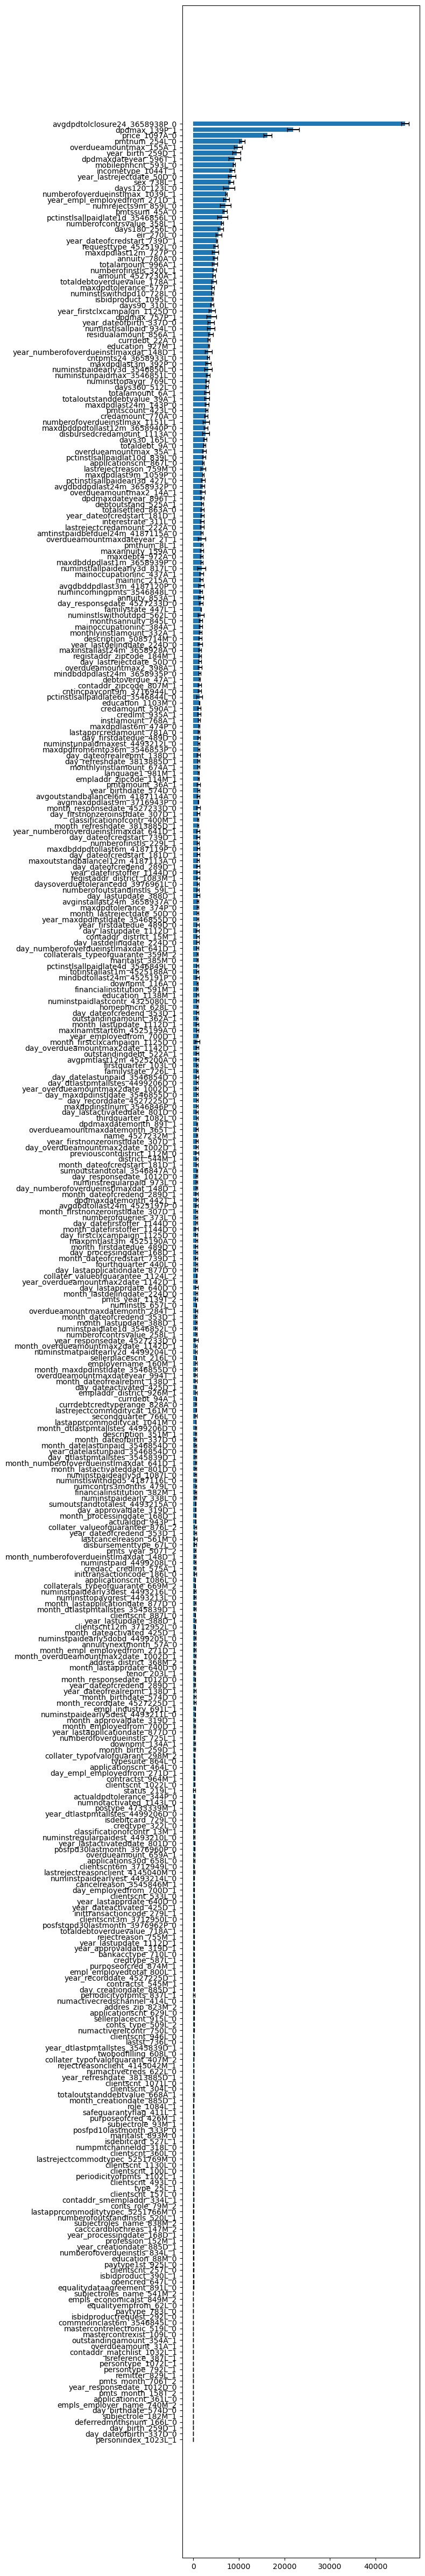

In [6]:
fimps.sort_values('fimp_mean', inplace=True)
display(fimps)

_, ax = plt.subplots(figsize=(8, 16*(len(fimps)//100)))
ax.barh(y=fimps['processed_Variable'], width=fimps['fimp_mean'], xerr=fimps['fimp_std'], capsize=3)
plt.tight_layout()
plt.show()

In [7]:
fimp_q50 = fimps['fimp_mean'].quantile(0.75)
print(fimp_q50)

fimps['smaller_than_q50'] = fimps['fimp_mean'] < fimp_q50
display(fimps)
display(fimps['smaller_than_q50'].sum())

1310.9123244285583


processed_Variable   fold_1_fimp   fold_2_fimp   fold_3_fimp  \
0              personindex_1023L_1      0.000000      0.000000      0.000000   
20          day_dateofbirth_337D_0      0.000000      0.000000      0.000000   
19                day_birth_259D_1      0.000000      0.000000      0.000000   
18         deferredmnthsnum_166L_0      0.000000      0.000000      0.000000   
17              subjectrole_182M_1      0.000000      0.000000      0.000000   
..                             ...           ...           ...           ...   
392        overdueamountmax_155A_1   8044.246902  10278.366586   9874.608341   
393                  pmtnum_254L_0  10117.662024  11558.028876  10340.742229   
394                  price_1097A_0  15394.252024  17088.097522  15532.264152   
395                  dpdmax_139P_1  22780.665033  21494.436419  20901.952681   
396  avgdpdtolclosure24_3658938P_0  45509.695607  47670.802368  46138.021296   

      fold_4_fimp   fold_5_fimp     fimp_mean     fimp_std  \
0        0.000000      0.000000      0.000000     0.000000   
20       0.000000      0.000000      0.000000     0.000000   
19       0.000000      0.000000      0.000000     0.000000   
18       0.000000      0.000000      0.000000     0.000000   
17       0.000000      0.000000      0.000000     0.000000   
..            ...           ...           ...          ...   
392  10244.084540  10633.373105   9814.935895   917.352314   
393  10309.903605  11183.849430  10702.037233   564.032257   
394  17504.548259  15918.031022  16287.438596   851.697516   
395  24021.323479  20553.906897  21950.456902  1283.386272   
396  47189.168666  45984.896168  46498.516821   802.842945   

                        Variable  \
0              personindex_1023L   
20              dateofbirth_337D   
19                    birth_259D   
18         deferredmnthsnum_166L   
17              subjectrole_182M   
..                           ...   
392        overdueamountmax_155A   
393                  pmtnum_254L   
394                  price_1097A   
395                  dpdmax_139P   
396  avgdpdtolclosure24_3658938P   

                                                                                                                                                                                                               Description  \
0                                                                                                                                                                   Order of the person specified on the application form.   
20                                                                                                                                                                                                 Client's date of birth.   
19                                                                                                                                                                                            Date of birth of the person.   
18                                                                                                                                                                                              Number of deferred months.   
17                                                                                                                                                                                 Subject role in active credit contract.   
..                                                                                                                                                                                                                     ...   
392                                                                                                                                                                           Maximal past due amount for active contract.   
393                                                                                                  

297

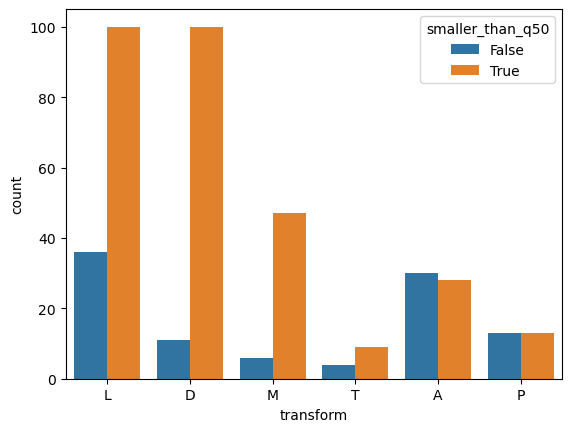

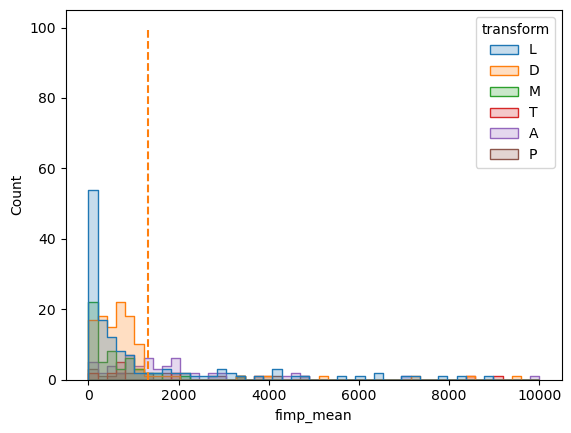

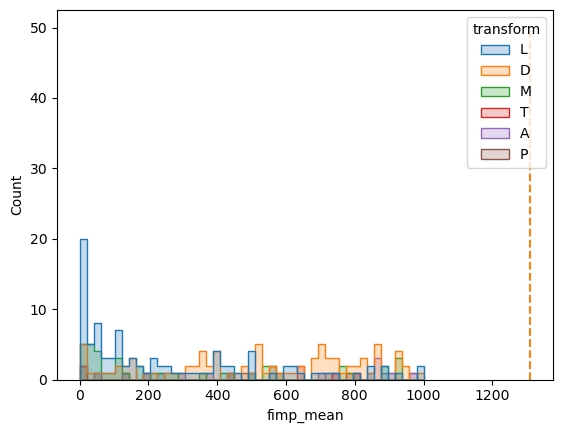

In [8]:
sns.countplot(data=fimps, x='transform', hue='smaller_than_q50')
plt.show()

_, ax = plt.subplots()
bins = np.linspace(0, 10000, 50)
sns.histplot(data=fimps, x='fimp_mean', hue='transform', element='step', bins=bins, ax=ax)
ax.vlines(fimp_q50, ymin=0, ymax=100, color='tab:orange', linestyles='dashed')
plt.show()

_, ax = plt.subplots()
bins = np.linspace(0, 1000, 50)
sns.histplot(data=fimps, x='fimp_mean', hue='transform', element='step', bins=bins, ax=ax)
ax.vlines(fimp_q50, ymin=0, ymax=50, color='tab:orange', linestyles='dashed')
plt.show()

### load train data

In [9]:
train_depth_paths = get_depth_paths(paths.parquet_files_dir, 'train')
print(f'number of test paths: {sum(len(v1) for v1 in train_depth_paths.values())}')

train_base_data = pl.read_parquet(
    paths.parquet_files_dir.joinpath('train/train_base.parquet')
)
train_base_data = train_base_data.cast(
    {
        'case_id': pl.Int64,
        'date_decision': pl.String,
        'MONTH': pl.Int64,
        'WEEK_NUM': pl.Int64,
        'target': pl.Int64,
    }
)
display(train_base_data)

number of test paths: 31


shape: (1_526_659, 5)
┌─────────┬───────────────┬────────┬──────────┬────────┐
│ case_id ┆ date_decision ┆ MONTH  ┆ WEEK_NUM ┆ target │
│ ---     ┆ ---           ┆ ---    ┆ ---      ┆ ---    │
│ i64     ┆ str           ┆ i64    ┆ i64      ┆ i64    │
╞═════════╪═══════════════╪════════╪══════════╪════════╡
│ 0       ┆ 2019-01-03    ┆ 201901 ┆ 0        ┆ 0      │
│ 1       ┆ 2019-01-03    ┆ 201901 ┆ 0        ┆ 0      │
│ 2       ┆ 2019-01-04    ┆ 201901 ┆ 0        ┆ 0      │
│ 3       ┆ 2019-01-03    ┆ 201901 ┆ 0        ┆ 0      │
│ 4       ┆ 2019-01-04    ┆ 201901 ┆ 0        ┆ 1      │
│ …       ┆ …             ┆ …      ┆ …        ┆ …      │
│ 2703450 ┆ 2020-10-05    ┆ 202010 ┆ 91       ┆ 0      │
│ 2703451 ┆ 2020-10-05    ┆ 202010 ┆ 91       ┆ 0      │
│ 2703452 ┆ 2020-10-05    ┆ 202010 ┆ 91       ┆ 0      │
│ 2703453 ┆ 2020-10-05    ┆ 202010 ┆ 91       ┆ 0      │
│ 2703454 ┆ 2020-10-05    ┆ 202010 ┆ 91       ┆ 0      │
└─────────┴───────────────┴────────┴──────────┴────────┘

In [10]:
%%time


depth_data = merge_dataset(
    train_base_data,
    train_depth_paths,
    bool_features,
    float64_features,
    string_features,
    date_features,
    None,
    '012'
)
display(depth_data)
display(depth_data.dtypes.value_counts())

loading `static_0`
	(1003757, 168)
	(522902, 168)
loading `static_cb_0`
	(1500476, 53)
loading `applprev_1`


shape: (3_887_684, 41)
┌─────────┬────────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ case_id ┆ actualdpd_ ┆ annuity_8 ┆ approvald ┆ … ┆ rejectrea ┆ revolving ┆ status_21 ┆ tenor_203 │
│ ---     ┆ 943P       ┆ 53A       ┆ ate_319D  ┆   ┆ sonclient ┆ account_3 ┆ 9L        ┆ L         │
│ i64     ┆ ---        ┆ ---       ┆ ---       ┆   ┆ _4145042M ┆ 94A       ┆ ---       ┆ ---       │
│         ┆ f32        ┆ f32       ┆ date      ┆   ┆ ---       ┆ ---       ┆ str       ┆ f32       │
│         ┆            ┆           ┆           ┆   ┆ str       ┆ f32       ┆           ┆           │
╞═════════╪════════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 2       ┆ 0.0        ┆ 640.20001 ┆ null      ┆ … ┆ a55475b1  ┆ null      ┆ D         ┆ 24.0      │
│         ┆            ┆ 2         ┆           ┆   ┆           ┆           ┆           ┆           │
│ 2       ┆ 0.0        ┆ 1682.4000 ┆ null      ┆ … ┆ a55475b1  ┆ null      ┆ D         ┆ 12.0      │
│         ┆            ┆ 24        ┆           ┆   ┆           ┆           ┆           ┆           │
│ 3       ┆ 0.0        ┆ 6140.0    ┆ null      ┆ … ┆ a55475b1  ┆ null      ┆ D         ┆ 12.0      │
│ 4       ┆ 0.0        ┆ 2556.6000 ┆ null      ┆ … ┆ a55475b1  ┆ null      ┆ T         ┆ 24.0      │
│         ┆            ┆ 98        ┆           ┆   ┆           ┆           ┆           ┆           │
│ 5       ┆ 0.0        ┆ null      ┆ null      ┆ … ┆ a55475b1  ┆ null      ┆ T         ┆ null      │
│ …       ┆ …          ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …         │
│ 2651092 ┆ 0.0        ┆ 0.0       ┆ null      ┆ … ┆ P94_109_1 ┆ null      ┆ D         ┆ null      │
│         ┆            ┆           ┆           ┆   ┆ 43        ┆           ┆           ┆           │
│ 2651092 ┆ 0.0        ┆ 4366.0    ┆ 2017-11-0 ┆ … ┆ a55475b1  ┆ null      ┆ K         ┆ 5.0       │
│         ┆            ┆           ┆ 9         ┆   ┆           ┆           ┆           ┆           │
│ 2651092 ┆ 0.0        ┆ 2632.1999 ┆ 2015-12-1 ┆ … ┆ a55475b1  ┆ null      ┆ K         ┆ 14.0      │
│         ┆            ┆ 51        ┆ 1         ┆   ┆           ┆           ┆           ┆           │
│ 2651092 ┆ 0.0        ┆ null      ┆ 2014-02-1 ┆ … ┆ a55475b1  ┆ 6.8053100 ┆ K         ┆ null      │
│         ┆            ┆           ┆ 5         ┆   ┆           ┆ 8e8       ┆           ┆           │
│ 2651092 ┆ 0.0        ┆ 3119.1999 ┆ 2012-12-1 ┆ … ┆ a55475b1  ┆ null      ┆ K         ┆ 12.0      │
│         ┆            ┆ 51        ┆ 2         ┆   ┆           ┆           ┆           ┆           │
└─────────┴────────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

	(782997, 40)


shape: (2_638_295, 41)
┌─────────┬────────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ case_id ┆ actualdpd_ ┆ annuity_8 ┆ approvald ┆ … ┆ rejectrea ┆ revolving ┆ status_21 ┆ tenor_203 │
│ ---     ┆ 943P       ┆ 53A       ┆ ate_319D  ┆   ┆ sonclient ┆ account_3 ┆ 9L        ┆ L         │
│ i64     ┆ ---        ┆ ---       ┆ ---       ┆   ┆ _4145042M ┆ 94A       ┆ ---       ┆ ---       │
│         ┆ f32        ┆ f32       ┆ date      ┆   ┆ ---       ┆ ---       ┆ str       ┆ f32       │
│         ┆            ┆           ┆           ┆   ┆ str       ┆ f32       ┆           ┆           │
╞═════════╪════════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 40704   ┆ 0.0        ┆ 7204.6000 ┆ null      ┆ … ┆ P94_109_1 ┆ null      ┆ D         ┆ 12.0      │
│         ┆            ┆ 98        ┆           ┆   ┆ 43        ┆           ┆           ┆           │
│ 40734   ┆ 0.0        ┆ 3870.1999 ┆ null      ┆ … ┆ P94_109_1 ┆ null      ┆ D         ┆ 18.0      │
│         ┆            ┆ 51        ┆           ┆   ┆ 43        ┆           ┆           ┆           │
│ 40737   ┆ 0.0        ┆ 2324.4001 ┆ null      ┆ … ┆ a55475b1  ┆ null      ┆ D         ┆ 18.0      │
│         ┆            ┆ 46        ┆           ┆   ┆           ┆           ┆           ┆           │
│ 40791   ┆ 0.0        ┆ 3044.4001 ┆ null      ┆ … ┆ P94_109_1 ┆ null      ┆ D         ┆ 24.0      │
│         ┆            ┆ 46        ┆           ┆   ┆ 43        ┆           ┆           ┆           │
│ 40791   ┆ 0.0        ┆ 2320.8000 ┆ null      ┆ … ┆ a55475b1  ┆ null      ┆ D         ┆ 12.0      │
│         ┆            ┆ 49        ┆           ┆   ┆           ┆           ┆           ┆           │
│ …       ┆ …          ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …         │
│ 2703453 ┆ 0.0        ┆ 927.79998 ┆ 2014-01-2 ┆ … ┆ a55475b1  ┆ null      ┆ K         ┆ 18.0      │
│         ┆            ┆ 8         ┆ 2         ┆   ┆           ┆           ┆           ┆           │
│ 2703453 ┆ 0.0        ┆ 266.80001 ┆ 2013-06-2 ┆ … ┆ a55475b1  ┆ null      ┆ K         ┆ 12.0      │
│         ┆            ┆ 8         ┆ 9         ┆   ┆           ┆           ┆           ┆           │
│ 2703453 ┆ 0.0        ┆ 416.20001 ┆ null      ┆ … ┆ a55475b1  ┆ null      ┆ D         ┆ 6.0       │
│         ┆            ┆ 2         ┆           ┆   ┆           ┆           ┆           ┆           │
│ 2703454 ┆ 0.0        ┆ 2986.8000 ┆ 2020-06-2 ┆ … ┆ a55475b1  ┆ null      ┆ A         ┆ 6.0       │
│         ┆            ┆ 49        ┆ 1         ┆   ┆           ┆           ┆           ┆           │
│ 2703454 ┆ 0.0        ┆ 6726.6000 ┆ 2019-08-0 ┆ … ┆ a55475b1  ┆ null      ┆ K         ┆ 12.0      │
│         ┆            ┆ 98        ┆ 1         ┆   ┆           ┆           ┆           ┆           │
└─────────┴────────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

	(438525, 40)
loading `other_1`


shape: (51_109, 7)
┌─────────┬───────────────┬──────────────┬──────────────┬──────────────┬──────────────┬────────────┐
│ case_id ┆ amtdebitincom ┆ amtdebitoutg ┆ amtdepositba ┆ amtdepositin ┆ amtdepositou ┆ num_group1 │
│ ---     ┆ ing_4809443A  ┆ oing_4809440 ┆ lance_480944 ┆ coming_48094 ┆ tgoing_48094 ┆ ---        │
│ i64     ┆ ---           ┆ A            ┆ 1A           ┆ 44A          ┆ 42A          ┆ i64        │
│         ┆ f32           ┆ ---          ┆ ---          ┆ ---          ┆ ---          ┆            │
│         ┆               ┆ f32          ┆ f32          ┆ f32          ┆ f32          ┆            │
╞═════════╪═══════════════╪══════════════╪══════════════╪══════════════╪══════════════╪════════════╡
│ 43801   ┆ 12466.600586  ┆ 12291.200195 ┆ 914.200012   ┆ 0.0          ┆ 304.800018   ┆ 0          │
│ 43991   ┆ 3333.400146   ┆ 3273.400146  ┆ 0.0          ┆ 0.0          ┆ 0.0          ┆ 0          │
│ 44001   ┆ 10000.0       ┆ 10000.0      ┆ 0.0          ┆ 0.0          ┆ 0.0          ┆ 0          │
│ 44053   ┆ 0.0           ┆ 0.0          ┆ 2586.400146  ┆ 0.0          ┆ 88.800003    ┆ 0          │
│ 44130   ┆ 63.799999     ┆ 60.799999    ┆ 0.0          ┆ 0.0          ┆ 0.0          ┆ 0          │
│ …       ┆ …             ┆ …            ┆ …            ┆ …            ┆ …            ┆ …          │
│ 2703443 ┆ 344.600006    ┆ 343.399994   ┆ 0.0          ┆ 0.0          ┆ 0.0          ┆ 0          │
│ 2703448 ┆ 0.0           ┆ 0.0          ┆ 2184.199951  ┆ 0.0          ┆ 18.0         ┆ 0          │
│ 2703450 ┆ 0.0           ┆ 0.0          ┆ 0.0          ┆ 0.0          ┆ 0.0          ┆ 0          │
│ 2703451 ┆ 27500.0       ┆ 27477.599609 ┆ 0.0          ┆ 0.0          ┆ 0.0          ┆ 0          │
│ 2703453 ┆ 13454.0       ┆ 13333.400391 ┆ 822.0        ┆ 0.0          ┆ 6.8          ┆ 0          │
└─────────┴───────────────┴──────────────┴──────────────┴──────────────┴──────────────┴────────────┘

	(51109, 6)
loading `tax_registry_a_1`


shape: (3_275_770, 5)
┌─────────┬─────────────────┬───────────────┬────────────┬─────────────────────┐
│ case_id ┆ amount_4527230A ┆ name_4527232M ┆ num_group1 ┆ recorddate_4527225D │
│ ---     ┆ ---             ┆ ---           ┆ ---        ┆ ---                 │
│ i64     ┆ f32             ┆ str           ┆ i64        ┆ date                │
╞═════════╪═════════════════╪═══════════════╪════════════╪═════════════════════╡
│ 28631   ┆ 1946.0          ┆ f980a1ea      ┆ 2          ┆ 2019-09-13          │
│ 28631   ┆ 711.0           ┆ f980a1ea      ┆ 3          ┆ 2019-09-13          │
│ 28631   ┆ 3616.400146     ┆ f980a1ea      ┆ 0          ┆ 2019-09-13          │
│ 28631   ┆ 2600.0          ┆ f980a1ea      ┆ 1          ┆ 2019-09-13          │
│ 28632   ┆ 2564.0          ┆ 5f9b74f5      ┆ 5          ┆ 2019-09-13          │
│ …       ┆ …               ┆ …             ┆ …          ┆ …                   │
│ 2701515 ┆ 356.0           ┆ 5e180ef0      ┆ 7          ┆ 2020-10-09          │
│ 2701515 ┆ 479.800018      ┆ 5e180ef0      ┆ 6          ┆ 2020-10-09          │
│ 2702290 ┆ 850.0           ┆ 94721311      ┆ 1          ┆ 2020-10-13          │
│ 2702290 ┆ 850.0           ┆ 94721311      ┆ 2          ┆ 2020-10-13          │
│ 2702290 ┆ 850.0           ┆ 94721311      ┆ 0          ┆ 2020-10-13          │
└─────────┴─────────────────┴───────────────┴────────────┴─────────────────────┘

	(457934, 4)
loading `tax_registry_b_1`


shape: (1_107_933, 5)
┌─────────┬─────────────────┬────────────────────────┬───────────────┬────────────┐
│ case_id ┆ amount_4917619A ┆ deductiondate_4917603D ┆ name_4917606M ┆ num_group1 │
│ ---     ┆ ---             ┆ ---                    ┆ ---           ┆ ---        │
│ i64     ┆ f32             ┆ date                   ┆ str           ┆ i64        │
╞═════════╪═════════════════╪════════════════════════╪═══════════════╪════════════╡
│ 49435   ┆ 6885.0          ┆ 2019-10-16             ┆ 6b730375      ┆ 7          │
│ 49435   ┆ 6885.0          ┆ 2019-10-16             ┆ 6b730375      ┆ 1          │
│ 49435   ┆ 6885.0          ┆ 2019-10-16             ┆ 6b730375      ┆ 8          │
│ 49435   ┆ 6885.0          ┆ 2019-10-16             ┆ 6b730375      ┆ 3          │
│ 49435   ┆ 6885.0          ┆ 2019-10-16             ┆ 6b730375      ┆ 4          │
│ …       ┆ …               ┆ …                      ┆ …             ┆ …          │
│ 2703452 ┆ 7290.0          ┆ 2020-06-11             ┆ ad68e80f      ┆ 2          │
│ 2703452 ┆ 10638.0         ┆ 2020-08-05             ┆ ad68e80f      ┆ 4          │
│ 2703452 ┆ 15552.0         ┆ 2020-07-07             ┆ 3ba7682e      ┆ 3          │
│ 2703452 ┆ 6033.600098     ┆ 2020-05-05             ┆ 5502675a      ┆ 0          │
│ 2703452 ┆ 15228.0         ┆ 2020-06-11             ┆ ad68e80f      ┆ 1          │
└─────────┴─────────────────┴────────────────────────┴───────────────┴────────────┘

	(150732, 4)
loading `tax_registry_c_1`


shape: (3_343_800, 5)
┌─────────┬───────────────────┬────────────┬───────────────┬─────────────────────┐
│ case_id ┆ employername_160M ┆ num_group1 ┆ pmtamount_36A ┆ processingdate_168D │
│ ---     ┆ ---               ┆ ---        ┆ ---           ┆ ---                 │
│ i64     ┆ str               ┆ i64        ┆ f32           ┆ date                │
╞═════════╪═══════════════════╪════════════╪═══════════════╪═════════════════════╡
│ 357     ┆ c91b12ff          ┆ 5          ┆ 1100.0        ┆ 2018-08-08          │
│ 357     ┆ c91b12ff          ┆ 1          ┆ 1200.0        ┆ 2018-11-28          │
│ 357     ┆ c91b12ff          ┆ 4          ┆ 1200.0        ┆ 2018-09-10          │
│ 357     ┆ c91b12ff          ┆ 0          ┆ 1200.0        ┆ 2019-01-04          │
│ 357     ┆ c91b12ff          ┆ 3          ┆ 628.600037    ┆ 2018-10-08          │
│ …       ┆ …                 ┆ …          ┆ …             ┆ …                   │
│ 2629815 ┆ 378c3e37          ┆ 10         ┆ 1961.200073   ┆ 2019-10-22          │
│ 2629815 ┆ 378c3e37          ┆ 1          ┆ 1961.200073   ┆ 2019-10-22          │
│ 2629815 ┆ 378c3e37          ┆ 6          ┆ 1961.200073   ┆ 2019-10-22          │
│ 2629815 ┆ 378c3e37          ┆ 3          ┆ 1961.200073   ┆ 2019-10-22          │
│ 2629815 ┆ 378c3e37          ┆ 7          ┆ 301.800018    ┆ 2019-10-22          │
└─────────┴───────────────────┴────────────┴───────────────┴─────────────────────┘

	(482265, 4)
loading `credit_bureau_a_1`


shape: (4_108_212, 79)
┌─────────┬────────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ case_id ┆ annualeffe ┆ annualeff ┆ classific ┆ … ┆ totaldebt ┆ totaldebt ┆ totalouts ┆ totalouts │
│ ---     ┆ ctiverate_ ┆ ectiverat ┆ ationofco ┆   ┆ overdueva ┆ overdueva ┆ tanddebtv ┆ tanddebtv │
│ i64     ┆ 199L       ┆ e_63L     ┆ ntr_13M   ┆   ┆ lue_178A  ┆ lue_718A  ┆ alue_39A  ┆ alue_668A │
│         ┆ ---        ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│         ┆ f32        ┆ f32       ┆ str       ┆   ┆ f32       ┆ f32       ┆ f32       ┆ f32       │
╞═════════╪════════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 388     ┆ null       ┆ null      ┆ 4408ff0f  ┆ … ┆ 0.0       ┆ 0.0       ┆ 374419.5  ┆ 0.0       │
│ 388     ┆ null       ┆ null      ┆ ea6782cc  ┆ … ┆ null      ┆ null      ┆ null      ┆ null      │
│ 388     ┆ null       ┆ null      ┆ a55475b1  ┆ … ┆ null      ┆ null      ┆ null      ┆ null      │
│ 388     ┆ null       ┆ null      ┆ a55475b1  ┆ … ┆ null      ┆ null      ┆ null      ┆ null      │
│ 388     ┆ null       ┆ null      ┆ a55475b1  ┆ … ┆ null      ┆ null      ┆ null      ┆ null      │
│ …       ┆ …          ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …         │
│ 2588481 ┆ null       ┆ null      ┆ a55475b1  ┆ … ┆ null      ┆ null      ┆ null      ┆ null      │
│ 2588481 ┆ null       ┆ null      ┆ a55475b1  ┆ … ┆ null      ┆ null      ┆ null      ┆ null      │
│ 2588481 ┆ null       ┆ null      ┆ a55475b1  ┆ … ┆ null      ┆ null      ┆ null      ┆ null      │
│ 2588481 ┆ null       ┆ null      ┆ a55475b1  ┆ … ┆ null      ┆ null      ┆ null      ┆ null      │
│ 2588481 ┆ null       ┆ null      ┆ a55475b1  ┆ … ┆ null      ┆ null      ┆ null      ┆ null      │
└─────────┴────────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

	(335275, 78)


shape: (6_009_192, 79)
┌─────────┬────────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ case_id ┆ annualeffe ┆ annualeff ┆ classific ┆ … ┆ totaldebt ┆ totaldebt ┆ totalouts ┆ totalouts │
│ ---     ┆ ctiverate_ ┆ ectiverat ┆ ationofco ┆   ┆ overdueva ┆ overdueva ┆ tanddebtv ┆ tanddebtv │
│ i64     ┆ 199L       ┆ e_63L     ┆ ntr_13M   ┆   ┆ lue_178A  ┆ lue_718A  ┆ alue_39A  ┆ alue_668A │
│         ┆ ---        ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│         ┆ f32        ┆ f32       ┆ str       ┆   ┆ f32       ┆ f32       ┆ f32       ┆ f32       │
╞═════════╪════════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 19694   ┆ null       ┆ null      ┆ ea6782cc  ┆ … ┆ 0.0       ┆ 0.0       ┆ 43315.261 ┆ 0.0       │
│         ┆            ┆           ┆           ┆   ┆           ┆           ┆ 719       ┆           │
│ 19694   ┆ null       ┆ null      ┆ ea6782cc  ┆ … ┆ null      ┆ null      ┆ null      ┆ null      │
│ 19694   ┆ null       ┆ null      ┆ a55475b1  ┆ … ┆ null      ┆ null      ┆ null      ┆ null      │
│ 19694   ┆ null       ┆ null      ┆ a55475b1  ┆ … ┆ null      ┆ null      ┆ null      ┆ null      │
│ 19694   ┆ null       ┆ null      ┆ a55475b1  ┆ … ┆ null      ┆ null      ┆ null      ┆ null      │
│ …       ┆ …          ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …         │
│ 2651092 ┆ null       ┆ null      ┆ a55475b1  ┆ … ┆ null      ┆ null      ┆ null      ┆ null      │
│ 2651092 ┆ null       ┆ null      ┆ a55475b1  ┆ … ┆ null      ┆ null      ┆ null      ┆ null      │
│ 2651092 ┆ null       ┆ null      ┆ a55475b1  ┆ … ┆ null      ┆ null      ┆ null      ┆ null      │
│ 2651092 ┆ null       ┆ null      ┆ a55475b1  ┆ … ┆ null      ┆ null      ┆ null      ┆ null      │
│ 2651092 ┆ null       ┆ null      ┆ a55475b1  ┆ … ┆ null      ┆ null      ┆ null      ┆ null      │
└─────────┴────────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

	(549263, 78)


shape: (3_743_810, 79)
┌─────────┬────────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ case_id ┆ annualeffe ┆ annualeff ┆ classific ┆ … ┆ totaldebt ┆ totaldebt ┆ totalouts ┆ totalouts │
│ ---     ┆ ctiverate_ ┆ ectiverat ┆ ationofco ┆   ┆ overdueva ┆ overdueva ┆ tanddebtv ┆ tanddebtv │
│ i64     ┆ 199L       ┆ e_63L     ┆ ntr_13M   ┆   ┆ lue_178A  ┆ lue_718A  ┆ alue_39A  ┆ alue_668A │
│         ┆ ---        ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│         ┆ f32        ┆ f32       ┆ str       ┆   ┆ f32       ┆ f32       ┆ f32       ┆ f32       │
╞═════════╪════════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 40626   ┆ null       ┆ null      ┆ ea6782cc  ┆ … ┆ 0.0       ┆ 0.0       ┆ 200944.12 ┆ 0.0       │
│         ┆            ┆           ┆           ┆   ┆           ┆           ┆ 5         ┆           │
│ 40626   ┆ 68.300003  ┆ null      ┆ ea6782cc  ┆ … ┆ null      ┆ null      ┆ null      ┆ null      │
│ 40626   ┆ 38.299999  ┆ null      ┆ ea6782cc  ┆ … ┆ null      ┆ null      ┆ null      ┆ null      │
│ 40626   ┆ 96.300003  ┆ null      ┆ a55475b1  ┆ … ┆ null      ┆ null      ┆ null      ┆ null      │
│ 40626   ┆ 0.69       ┆ null      ┆ a55475b1  ┆ … ┆ null      ┆ null      ┆ null      ┆ null      │
│ …       ┆ …          ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …         │
│ 2683578 ┆ null       ┆ null      ┆ a55475b1  ┆ … ┆ null      ┆ null      ┆ null      ┆ null      │
│ 2683578 ┆ null       ┆ null      ┆ a55475b1  ┆ … ┆ null      ┆ null      ┆ null      ┆ null      │
│ 2683578 ┆ null       ┆ null      ┆ a55475b1  ┆ … ┆ null      ┆ null      ┆ null      ┆ null      │
│ 2683578 ┆ null       ┆ null      ┆ a55475b1  ┆ … ┆ null      ┆ null      ┆ null      ┆ null      │
│ 2683578 ┆ null       ┆ null      ┆ a55475b1  ┆ … ┆ null      ┆ null      ┆ null      ┆ null      │
└─────────┴────────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

	(325127, 78)


shape: (2_079_323, 79)
┌─────────┬────────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ case_id ┆ annualeffe ┆ annualeff ┆ classific ┆ … ┆ totaldebt ┆ totaldebt ┆ totalouts ┆ totalouts │
│ ---     ┆ ctiverate_ ┆ ectiverat ┆ ationofco ┆   ┆ overdueva ┆ overdueva ┆ tanddebtv ┆ tanddebtv │
│ i64     ┆ 199L       ┆ e_63L     ┆ ntr_13M   ┆   ┆ lue_178A  ┆ lue_718A  ┆ alue_39A  ┆ alue_668A │
│         ┆ ---        ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│         ┆ f32        ┆ f32       ┆ str       ┆   ┆ f32       ┆ f32       ┆ f32       ┆ f32       │
╞═════════╪════════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 51903   ┆ null       ┆ null      ┆ ea6782cc  ┆ … ┆ 0.0       ┆ null      ┆ 10602.110 ┆ null      │
│         ┆            ┆           ┆           ┆   ┆           ┆           ┆ 352       ┆           │
│ 51903   ┆ null       ┆ null      ┆ ea6782cc  ┆ … ┆ null      ┆ null      ┆ null      ┆ null      │
│ 51903   ┆ null       ┆ null      ┆ a55475b1  ┆ … ┆ null      ┆ null      ┆ null      ┆ null      │
│ 51903   ┆ null       ┆ null      ┆ a55475b1  ┆ … ┆ null      ┆ null      ┆ null      ┆ null      │
│ 51903   ┆ null       ┆ null      ┆ a55475b1  ┆ … ┆ null      ┆ null      ┆ null      ┆ null      │
│ …       ┆ …          ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …         │
│ 2703454 ┆ null       ┆ null      ┆ a55475b1  ┆ … ┆ null      ┆ null      ┆ null      ┆ null      │
│ 2703454 ┆ null       ┆ null      ┆ a55475b1  ┆ … ┆ null      ┆ null      ┆ null      ┆ null      │
│ 2703454 ┆ null       ┆ null      ┆ a55475b1  ┆ … ┆ null      ┆ null      ┆ null      ┆ null      │
│ 2703454 ┆ null       ┆ null      ┆ a55475b1  ┆ … ┆ null      ┆ null      ┆ null      ┆ null      │
│ 2703454 ┆ null       ┆ null      ┆ a55475b1  ┆ … ┆ null      ┆ null      ┆ null      ┆ null      │
└─────────┴────────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

	(176608, 78)
loading `credit_bureau_b_1`


shape: (85_791, 45)
┌─────────┬────────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ case_id ┆ amount_111 ┆ classific ┆ contractd ┆ … ┆ subjectro ┆ subjectro ┆ totalamou ┆ totalamou │
│ ---     ┆ 5A         ┆ ationofco ┆ ate_551D  ┆   ┆ le_326M   ┆ le_43M    ┆ nt_503A   ┆ nt_881A   │
│ i64     ┆ ---        ┆ ntr_1114M ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│         ┆ f32        ┆ ---       ┆ date      ┆   ┆ str       ┆ str       ┆ f32       ┆ f32       │
│         ┆            ┆ str       ┆           ┆   ┆           ┆           ┆           ┆           │
╞═════════╪════════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 467     ┆ null       ┆ ea6782cc  ┆ 2011-06-1 ┆ … ┆ fa4f56f1  ┆ ab3c25cf  ┆ 3e6       ┆ 10000.0   │
│         ┆            ┆           ┆ 5         ┆   ┆           ┆           ┆           ┆           │
│ 467     ┆ null       ┆ ea6782cc  ┆ 2019-01-0 ┆ … ┆ ab3c25cf  ┆ ab3c25cf  ┆ 78000.0   ┆ 960000.0  │
│         ┆            ┆           ┆ 4         ┆   ┆           ┆           ┆           ┆           │
│ 467     ┆ 78000.0    ┆ ea6782cc  ┆ 2016-10-2 ┆ … ┆ a55475b1  ┆ a55475b1  ┆ null      ┆ null      │
│         ┆            ┆           ┆ 5         ┆   ┆           ┆           ┆           ┆           │
│ 1445    ┆ null       ┆ ea6782cc  ┆ 2015-01-3 ┆ … ┆ daf49a8a  ┆ ab3c25cf  ┆ 400000.0  ┆ 100000.0  │
│         ┆            ┆           ┆ 0         ┆   ┆           ┆           ┆           ┆           │
│ 1445    ┆ null       ┆ 01f63ac8  ┆ 2014-09-1 ┆ … ┆ ab3c25cf  ┆ ab3c25cf  ┆ 396800.62 ┆ 184587.79 │
│         ┆            ┆           ┆ 2         ┆   ┆           ┆           ┆ 5         ┆ 6875      │
│ …       ┆ …          ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …         │
│ 2703357 ┆ null       ┆ ea6782cc  ┆ 2018-11-1 ┆ … ┆ ab3c25cf  ┆ ab3c25cf  ┆ 72000.0   ┆ 68996.0   │
│         ┆            ┆           ┆ 7         ┆   ┆           ┆           ┆           ┆           │
│ 2703357 ┆ 731886.062 ┆ 07b11743  ┆ 2018-04-1 ┆ … ┆ ab3c25cf  ┆ ab3c25cf  ┆ 731886.06 ┆ 490729.21 │
│         ┆ 5          ┆           ┆ 7         ┆   ┆           ┆           ┆ 25        ┆ 875       │
│ 2703377 ┆ null       ┆ ea6782cc  ┆ 2014-01-0 ┆ … ┆ ab3c25cf  ┆ ab3c25cf  ┆ 0.0       ┆ 205540.0  │
│         ┆            ┆           ┆ 4         ┆   ┆           ┆           ┆           ┆           │
│ 2703436 ┆ null       ┆ ea6782cc  ┆ 2018-05-1 ┆ … ┆ ab3c25cf  ┆ ab3c25cf  ┆ 40000.0   ┆ 0.0       │
│         ┆            ┆           ┆ 0         ┆   ┆           ┆           ┆           ┆           │
│ 2703436 ┆ 800000.0   ┆ ea6782cc  ┆ 2017-10-1 ┆ … ┆ ab3c25cf  ┆ ab3c25cf  ┆ 800000.0  ┆ 131932.0  │
│         ┆            ┆           ┆ 7         ┆   ┆           ┆           ┆           ┆           │
└─────────┴────────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

	(36500, 44)
loading `deposit_1`


shape: (145_086, 5)
┌─────────┬──────────────┬──────────────────────┬────────────┬──────────────────┐
│ case_id ┆ amount_416A  ┆ contractenddate_991D ┆ num_group1 ┆ openingdate_313D │
│ ---     ┆ ---          ┆ ---                  ┆ ---        ┆ ---              │
│ i64     ┆ f32          ┆ date                 ┆ i64        ┆ date             │
╞═════════╪══════════════╪══════════════════════╪════════════╪══════════════════╡
│ 225     ┆ 0.0          ┆ null                 ┆ 0          ┆ 2016-08-16       │
│ 331     ┆ 260.373993   ┆ 2018-03-18           ┆ 0          ┆ 2015-03-19       │
│ 358     ┆ 0.0          ┆ null                 ┆ 0          ┆ 2014-09-02       │
│ 390     ┆ 211748.53125 ┆ 2017-07-22           ┆ 0          ┆ 2014-07-23       │
│ 390     ┆ 223.680008   ┆ null                 ┆ 2          ┆ 2016-06-08       │
│ …       ┆ …            ┆ …                    ┆ …          ┆ …                │
│ 2703430 ┆ 22918.005859 ┆ null                 ┆ 8          ┆ 2016-11-26       │
│ 2703430 ┆ 0.0          ┆ null                 ┆ 2          ┆ 2014-02-14       │
│ 2703439 ┆ 219.984009   ┆ null                 ┆ 0          ┆ 2016-11-25       │
│ 2703453 ┆ 44916.644531 ┆ 2018-05-28           ┆ 1          ┆ 2015-05-29       │
│ 2703453 ┆ 0.0          ┆ null                 ┆ 0          ┆ 2014-08-18       │
└─────────┴──────────────┴──────────────────────┴────────────┴──────────────────┘

	(105111, 4)
loading `person_1`


shape: (2_973_991, 37)
┌─────────┬────────────┬────────────┬───────────┬───┬───────────┬───────────┬──────────┬───────────┐
│ case_id ┆ birth_259D ┆ birthdate_ ┆ childnum_ ┆ … ┆ role_993L ┆ safeguara ┆ sex_738L ┆ type_25L  │
│ ---     ┆ ---        ┆ 87D        ┆ 185L      ┆   ┆ ---       ┆ ntyflag_4 ┆ ---      ┆ ---       │
│ i64     ┆ date       ┆ ---        ┆ ---       ┆   ┆ str       ┆ 11L       ┆ str      ┆ str       │
│         ┆            ┆ date       ┆ f32       ┆   ┆           ┆ ---       ┆          ┆           │
│         ┆            ┆            ┆           ┆   ┆           ┆ bool      ┆          ┆           │
╞═════════╪════════════╪════════════╪═══════════╪═══╪═══════════╪═══════════╪══════════╪═══════════╡
│ 0       ┆ 1986-07-01 ┆ null       ┆ null      ┆ … ┆ null      ┆ true      ┆ F        ┆ PRIMARY_M │
│         ┆            ┆            ┆           ┆   ┆           ┆           ┆          ┆ OBILE     │
│ 0       ┆ null       ┆ null       ┆ null      ┆ … ┆ null      ┆ true      ┆ null     ┆ PHONE     │
│ 0       ┆ null       ┆ null       ┆ null      ┆ … ┆ null      ┆ true      ┆ null     ┆ PHONE     │
│ 0       ┆ null       ┆ null       ┆ null      ┆ … ┆ null      ┆ true      ┆ null     ┆ PHONE     │
│ 1       ┆ 1957-08-01 ┆ null       ┆ null      ┆ … ┆ null      ┆ true      ┆ M        ┆ PRIMARY_M │
│         ┆            ┆            ┆           ┆   ┆           ┆           ┆          ┆ OBILE     │
│ …       ┆ …          ┆ …          ┆ …         ┆ … ┆ …         ┆ …         ┆ …        ┆ …         │
│ 2703451 ┆ null       ┆ null       ┆ null      ┆ … ┆ null      ┆ true      ┆ null     ┆ HOME_PHON │
│         ┆            ┆            ┆           ┆   ┆           ┆           ┆          ┆ E         │
│ 2703452 ┆ 1977-08-01 ┆ null       ┆ null      ┆ … ┆ null      ┆ false     ┆ M        ┆ PRIMARY_M │
│         ┆            ┆            ┆           ┆   ┆           ┆           ┆          ┆ OBILE     │
│ 2703453 ┆ 1950-02-01 ┆ null       ┆ null      ┆ … ┆ null      ┆ false     ┆ F        ┆ PRIMARY_M │
│         ┆            ┆            ┆           ┆   ┆           ┆           ┆          ┆ OBILE     │
│ 2703453 ┆ null       ┆ null       ┆ null      ┆ … ┆ null      ┆ true      ┆ null     ┆ HOME_PHON │
│         ┆            ┆            ┆           ┆   ┆           ┆           ┆          ┆ E         │
│ 2703454 ┆ 1948-04-01 ┆ null       ┆ null      ┆ … ┆ null      ┆ true      ┆ F        ┆ PRIMARY_M │
│         ┆            ┆            ┆           ┆   ┆           ┆           ┆          ┆ OBILE     │
└─────────┴────────────┴────────────┴───────────┴───┴───────────┴───────────┴──────────┴───────────┘

	(1526659, 36)
loading `debitcard_1`


shape: (157_302, 6)
┌─────────┬──────────────────┬──────────────────┬──────────────────┬────────────┬──────────────────┐
│ case_id ┆ last180dayaverag ┆ last180dayturnov ┆ last30dayturnove ┆ num_group1 ┆ openingdate_857D │
│ ---     ┆ ebalance_704A    ┆ er_1134A         ┆ r_651A           ┆ ---        ┆ ---              │
│ i64     ┆ ---              ┆ ---              ┆ ---              ┆ i64        ┆ date             │
│         ┆ f32              ┆ f32              ┆ f32              ┆            ┆                  │
╞═════════╪══════════════════╪══════════════════╪══════════════════╪════════════╪══════════════════╡
│ 225     ┆ null             ┆ null             ┆ null             ┆ 0          ┆ 2016-08-16       │
│ 331     ┆ null             ┆ null             ┆ null             ┆ 0          ┆ 2015-03-19       │
│ 358     ┆ null             ┆ null             ┆ null             ┆ 0          ┆ 2014-09-02       │
│ 390     ┆ null             ┆ null             ┆ null             ┆ 0          ┆ 2014-07-23       │
│ 390     ┆ null             ┆ null             ┆ null             ┆ 2          ┆ 2016-06-08       │
│ …       ┆ …                ┆ …                ┆ …                ┆ …          ┆ …                │
│ 2703430 ┆ null             ┆ null             ┆ null             ┆ 8          ┆ 2016-11-26       │
│ 2703430 ┆ null             ┆ null             ┆ null             ┆ 2          ┆ 2014-02-14       │
│ 2703439 ┆ null             ┆ null             ┆ null             ┆ 0          ┆ 2016-11-25       │
│ 2703453 ┆ null             ┆ null             ┆ null             ┆ 1          ┆ 2015-05-29       │
│ 2703453 ┆ null             ┆ null             ┆ null             ┆ 0          ┆ 2014-08-18       │
└─────────┴──────────────────┴──────────────────┴──────────────────┴────────────┴──────────────────┘

	(111772, 5)
loading `applprev_2`


shape: (14_075_487, 6)
┌─────────┬─────────────────────┬──────────────────┬─────────────────────┬────────────┬────────────┐
│ case_id ┆ cacccardblochreas_1 ┆ conts_type_509L  ┆ credacc_cards_statu ┆ num_group1 ┆ num_group2 │
│ ---     ┆ 47M                 ┆ ---              ┆ s_52L               ┆ ---        ┆ ---        │
│ i64     ┆ ---                 ┆ str              ┆ ---                 ┆ i64        ┆ i64        │
│         ┆ str                 ┆                  ┆ str                 ┆            ┆            │
╞═════════╪═════════════════════╪══════════════════╪═════════════════════╪════════════╪════════════╡
│ 2       ┆ null                ┆ EMPLOYMENT_PHONE ┆ null                ┆ 1          ┆ 1          │
│ 2       ┆ null                ┆ EMPLOYMENT_PHONE ┆ null                ┆ 0          ┆ 1          │
│ 2       ┆ null                ┆ PRIMARY_MOBILE   ┆ null                ┆ 0          ┆ 0          │
│ 2       ┆ null                ┆ PRIMARY_MOBILE   ┆ null                ┆ 1          ┆ 0          │
│ 3       ┆ null                ┆ PRIMARY_MOBILE   ┆ null                ┆ 0          ┆ 1          │
│ …       ┆ …                   ┆ …                ┆ …                   ┆ …          ┆ …          │
│ 2703454 ┆ a55475b1            ┆ PRIMARY_MOBILE   ┆ null                ┆ 0          ┆ 0          │
│ 2703454 ┆ a55475b1            ┆ null             ┆ null                ┆ 1          ┆ 3          │
│ 2703454 ┆ a55475b1            ┆ null             ┆ null                ┆ 0          ┆ 1          │
│ 2703454 ┆ a55475b1            ┆ PRIMARY_MOBILE   ┆ null                ┆ 1          ┆ 0          │
│ 2703454 ┆ a55475b1            ┆ HOME_PHONE       ┆ null                ┆ 1          ┆ 1          │
└─────────┴─────────────────────┴──────────────────┴─────────────────────┴────────────┴────────────┘

	(1221522, 4)
loading `person_2`


shape: (1_643_410, 11)
┌─────────┬────────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ case_id ┆ addres_dis ┆ addres_ro ┆ addres_zi ┆ … ┆ empls_emp ┆ num_group ┆ num_group ┆ relatedpe │
│ ---     ┆ trict_368M ┆ le_871L   ┆ p_823M    ┆   ┆ loyer_nam ┆ 1         ┆ 2         ┆ rsons_rol │
│ i64     ┆ ---        ┆ ---       ┆ ---       ┆   ┆ e_740M    ┆ ---       ┆ ---       ┆ e_762T    │
│         ┆ str        ┆ str       ┆ str       ┆   ┆ ---       ┆ i64       ┆ i64       ┆ ---       │
│         ┆            ┆           ┆           ┆   ┆ str       ┆           ┆           ┆ str       │
╞═════════╪════════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 5       ┆ a55475b1   ┆ null      ┆ a55475b1  ┆ … ┆ a55475b1  ┆ 0         ┆ 0         ┆ null      │
│ 6       ┆ P55_110_32 ┆ CONTACT   ┆ P10_68_40 ┆ … ┆ a55475b1  ┆ 0         ┆ 0         ┆ null      │
│ 6       ┆ P55_110_32 ┆ PERMANENT ┆ P10_68_40 ┆ … ┆ a55475b1  ┆ 0         ┆ 1         ┆ null      │
│ 6       ┆ P204_92_17 ┆ CONTACT   ┆ P65_136_1 ┆ … ┆ a55475b1  ┆ 1         ┆ 0         ┆ OTHER_REL │
│         ┆ 8          ┆           ┆ 69        ┆   ┆           ┆           ┆           ┆ ATIVE     │
│ 6       ┆ P191_109_7 ┆ CONTACT   ┆ P10_68_40 ┆ … ┆ a55475b1  ┆ 1         ┆ 1         ┆ OTHER_REL │
│         ┆ 5          ┆           ┆           ┆   ┆           ┆           ┆           ┆ ATIVE     │
│ …       ┆ …          ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …         │
│ 2703450 ┆ a55475b1   ┆ null      ┆ a55475b1  ┆ … ┆ a55475b1  ┆ 0         ┆ 0         ┆ null      │
│ 2703451 ┆ a55475b1   ┆ null      ┆ a55475b1  ┆ … ┆ a55475b1  ┆ 0         ┆ 0         ┆ null      │
│ 2703452 ┆ a55475b1   ┆ null      ┆ a55475b1  ┆ … ┆ a55475b1  ┆ 0         ┆ 0         ┆ null      │
│ 2703453 ┆ a55475b1   ┆ null      ┆ a55475b1  ┆ … ┆ a55475b1  ┆ 0         ┆ 0         ┆ null      │
│ 2703454 ┆ a55475b1   ┆ null      ┆ a55475b1  ┆ … ┆ a55475b1  ┆ 0         ┆ 0         ┆ null      │
└─────────┴────────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

	(1435041, 9)
loading `credit_bureau_a_2`


shape: (5_296_031, 19)
┌─────────┬────────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ case_id ┆ collater_t ┆ collater_ ┆ collater_ ┆ … ┆ pmts_year ┆ pmts_year ┆ subjectro ┆ subjectro │
│ ---     ┆ ypofvalofg ┆ typofvalo ┆ valueofgu ┆   ┆ _1139T    ┆ _507T     ┆ les_name_ ┆ les_name_ │
│ i64     ┆ uarant_298 ┆ fguarant_ ┆ arantee_1 ┆   ┆ ---       ┆ ---       ┆ 541M      ┆ 838M      │
│         ┆ M          ┆ 407M      ┆ 124L      ┆   ┆ f32       ┆ f32       ┆ ---       ┆ ---       │
│         ┆ ---        ┆ ---       ┆ ---       ┆   ┆           ┆           ┆ str       ┆ str       │
│         ┆ str        ┆ str       ┆ f32       ┆   ┆           ┆           ┆           ┆           │
╞═════════╪════════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 388     ┆ 8fd95e4b   ┆ a55475b1  ┆ 0.0       ┆ … ┆ 2018.0    ┆ null      ┆ a55475b1  ┆ ab3c25cf  │
│ 388     ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ 2018.0    ┆ null      ┆ a55475b1  ┆ a55475b1  │
│ 388     ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ 2018.0    ┆ null      ┆ a55475b1  ┆ a55475b1  │
│ 388     ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ 2018.0    ┆ null      ┆ a55475b1  ┆ a55475b1  │
│ 388     ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ 2018.0    ┆ null      ┆ a55475b1  ┆ a55475b1  │
│ …       ┆ …          ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …         │
│ 2548729 ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ 2019.0    ┆ null      ┆ a55475b1  ┆ a55475b1  │
│ 2548729 ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ 2019.0    ┆ null      ┆ a55475b1  ┆ a55475b1  │
│ 2548729 ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ 2019.0    ┆ null      ┆ a55475b1  ┆ a55475b1  │
│ 2548729 ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ 2019.0    ┆ null      ┆ a55475b1  ┆ a55475b1  │
│ 2548729 ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ 2020.0    ┆ null      ┆ a55475b1  ┆ a55475b1  │
└─────────┴────────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

	(98303, 17)


shape: (7_861_809, 19)
┌─────────┬────────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ case_id ┆ collater_t ┆ collater_ ┆ collater_ ┆ … ┆ pmts_year ┆ pmts_year ┆ subjectro ┆ subjectro │
│ ---     ┆ ypofvalofg ┆ typofvalo ┆ valueofgu ┆   ┆ _1139T    ┆ _507T     ┆ les_name_ ┆ les_name_ │
│ i64     ┆ uarant_298 ┆ fguarant_ ┆ arantee_1 ┆   ┆ ---       ┆ ---       ┆ 541M      ┆ 838M      │
│         ┆ M          ┆ 407M      ┆ 124L      ┆   ┆ f32       ┆ f32       ┆ ---       ┆ ---       │
│         ┆ ---        ┆ ---       ┆ ---       ┆   ┆           ┆           ┆ str       ┆ str       │
│         ┆ str        ┆ str       ┆ f32       ┆   ┆           ┆           ┆           ┆           │
╞═════════╪════════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 6683    ┆ 8fd95e4b   ┆ a55475b1  ┆ 6.7428e6  ┆ … ┆ 2017.0    ┆ null      ┆ a55475b1  ┆ ab3c25cf  │
│ 6683    ┆ 8fd95e4b   ┆ a55475b1  ┆ 6.7e6     ┆ … ┆ 2017.0    ┆ null      ┆ a55475b1  ┆ a55475b1  │
│ 6683    ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ 2017.0    ┆ null      ┆ a55475b1  ┆ a55475b1  │
│ 6683    ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ 2017.0    ┆ null      ┆ a55475b1  ┆ a55475b1  │
│ 6683    ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ 2017.0    ┆ null      ┆ a55475b1  ┆ a55475b1  │
│ …       ┆ …          ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …         │
│ 2570525 ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ 2019.0    ┆ null      ┆ a55475b1  ┆ a55475b1  │
│ 2570525 ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ 2019.0    ┆ null      ┆ a55475b1  ┆ a55475b1  │
│ 2570525 ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ 2019.0    ┆ null      ┆ a55475b1  ┆ a55475b1  │
│ 2570525 ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ 2019.0    ┆ null      ┆ a55475b1  ┆ a55475b1  │
│ 2570525 ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ 2020.0    ┆ null      ┆ a55475b1  ┆ a55475b1  │
└─────────┴────────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

	(118481, 17)


shape: (4_386_062, 19)
┌─────────┬────────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ case_id ┆ collater_t ┆ collater_ ┆ collater_ ┆ … ┆ pmts_year ┆ pmts_year ┆ subjectro ┆ subjectro │
│ ---     ┆ ypofvalofg ┆ typofvalo ┆ valueofgu ┆   ┆ _1139T    ┆ _507T     ┆ les_name_ ┆ les_name_ │
│ i64     ┆ uarant_298 ┆ fguarant_ ┆ arantee_1 ┆   ┆ ---       ┆ ---       ┆ 541M      ┆ 838M      │
│         ┆ M          ┆ 407M      ┆ 124L      ┆   ┆ f32       ┆ f32       ┆ ---       ┆ ---       │
│         ┆ ---        ┆ ---       ┆ ---       ┆   ┆           ┆           ┆ str       ┆ str       │
│         ┆ str        ┆ str       ┆ f32       ┆   ┆           ┆           ┆           ┆           │
╞═════════╪════════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 56408   ┆ a55475b1   ┆ 8fd95e4b  ┆ null      ┆ … ┆ null      ┆ 2012.0    ┆ ab3c25cf  ┆ a55475b1  │
│ 56408   ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ null      ┆ 2012.0    ┆ a55475b1  ┆ a55475b1  │
│ 56408   ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ null      ┆ 2012.0    ┆ a55475b1  ┆ a55475b1  │
│ 56408   ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ null      ┆ 2012.0    ┆ a55475b1  ┆ a55475b1  │
│ 56408   ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ null      ┆ 2012.0    ┆ a55475b1  ┆ a55475b1  │
│ …       ┆ …          ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …         │
│ 2703454 ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ null      ┆ 2020.0    ┆ a55475b1  ┆ a55475b1  │
│ 2703454 ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ null      ┆ 2020.0    ┆ a55475b1  ┆ a55475b1  │
│ 2703454 ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ null      ┆ 2020.0    ┆ a55475b1  ┆ a55475b1  │
│ 2703454 ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ null      ┆ 2020.0    ┆ a55475b1  ┆ a55475b1  │
│ 2703454 ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ null      ┆ 2021.0    ┆ a55475b1  ┆ a55475b1  │
└─────────┴────────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

	(23734, 17)


shape: (17_893_536, 19)
┌─────────┬────────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ case_id ┆ collater_t ┆ collater_ ┆ collater_ ┆ … ┆ pmts_year ┆ pmts_year ┆ subjectro ┆ subjectro │
│ ---     ┆ ypofvalofg ┆ typofvalo ┆ valueofgu ┆   ┆ _1139T    ┆ _507T     ┆ les_name_ ┆ les_name_ │
│ i64     ┆ uarant_298 ┆ fguarant_ ┆ arantee_1 ┆   ┆ ---       ┆ ---       ┆ 541M      ┆ 838M      │
│         ┆ M          ┆ 407M      ┆ 124L      ┆   ┆ f32       ┆ f32       ┆ ---       ┆ ---       │
│         ┆ ---        ┆ ---       ┆ ---       ┆   ┆           ┆           ┆ str       ┆ str       │
│         ┆ str        ┆ str       ┆ f32       ┆   ┆           ┆           ┆           ┆           │
╞═════════╪════════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 13927   ┆ 8fd95e4b   ┆ a55475b1  ┆ 0.0       ┆ … ┆ 2017.0    ┆ null      ┆ a55475b1  ┆ ab3c25cf  │
│ 13927   ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ 2017.0    ┆ null      ┆ a55475b1  ┆ a55475b1  │
│ 13927   ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ 2017.0    ┆ null      ┆ a55475b1  ┆ a55475b1  │
│ 13927   ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ 2017.0    ┆ null      ┆ a55475b1  ┆ a55475b1  │
│ 13927   ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ 2017.0    ┆ null      ┆ a55475b1  ┆ a55475b1  │
│ …       ┆ …          ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …         │
│ 2593511 ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ null      ┆ 2019.0    ┆ a55475b1  ┆ a55475b1  │
│ 2593511 ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ null      ┆ 2019.0    ┆ a55475b1  ┆ a55475b1  │
│ 2593511 ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ null      ┆ 2019.0    ┆ a55475b1  ┆ a55475b1  │
│ 2593511 ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ null      ┆ 2019.0    ┆ a55475b1  ┆ a55475b1  │
│ 2593511 ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ null      ┆ 2020.0    ┆ a55475b1  ┆ a55475b1  │
└─────────┴────────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

	(156749, 17)


shape: (26_563_901, 19)
┌─────────┬────────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ case_id ┆ collater_t ┆ collater_ ┆ collater_ ┆ … ┆ pmts_year ┆ pmts_year ┆ subjectro ┆ subjectro │
│ ---     ┆ ypofvalofg ┆ typofvalo ┆ valueofgu ┆   ┆ _1139T    ┆ _507T     ┆ les_name_ ┆ les_name_ │
│ i64     ┆ uarant_298 ┆ fguarant_ ┆ arantee_1 ┆   ┆ ---       ┆ ---       ┆ 541M      ┆ 838M      │
│         ┆ M          ┆ 407M      ┆ 124L      ┆   ┆ f32       ┆ f32       ┆ ---       ┆ ---       │
│         ┆ ---        ┆ ---       ┆ ---       ┆   ┆           ┆           ┆ str       ┆ str       │
│         ┆ str        ┆ str       ┆ f32       ┆   ┆           ┆           ┆           ┆           │
╞═════════╪════════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 21161   ┆ 9a0c095e   ┆ a55475b1  ┆ 0.0       ┆ … ┆ 2017.0    ┆ null      ┆ a55475b1  ┆ ab3c25cf  │
│ 21161   ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ 2017.0    ┆ null      ┆ a55475b1  ┆ a55475b1  │
│ 21161   ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ 2017.0    ┆ null      ┆ a55475b1  ┆ a55475b1  │
│ 21161   ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ 2017.0    ┆ null      ┆ a55475b1  ┆ a55475b1  │
│ 21161   ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ 2017.0    ┆ null      ┆ a55475b1  ┆ a55475b1  │
│ …       ┆ …          ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …         │
│ 2619253 ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ null      ┆ 2019.0    ┆ a55475b1  ┆ a55475b1  │
│ 2619253 ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ null      ┆ 2019.0    ┆ a55475b1  ┆ a55475b1  │
│ 2619253 ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ null      ┆ 2019.0    ┆ a55475b1  ┆ a55475b1  │
│ 2619253 ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ null      ┆ 2019.0    ┆ a55475b1  ┆ a55475b1  │
│ 2619253 ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ null      ┆ 2020.0    ┆ a55475b1  ┆ a55475b1  │
└─────────┴────────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

	(190486, 17)


shape: (27_025_737, 19)
┌─────────┬────────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ case_id ┆ collater_t ┆ collater_ ┆ collater_ ┆ … ┆ pmts_year ┆ pmts_year ┆ subjectro ┆ subjectro │
│ ---     ┆ ypofvalofg ┆ typofvalo ┆ valueofgu ┆   ┆ _1139T    ┆ _507T     ┆ les_name_ ┆ les_name_ │
│ i64     ┆ uarant_298 ┆ fguarant_ ┆ arantee_1 ┆   ┆ ---       ┆ ---       ┆ 541M      ┆ 838M      │
│         ┆ M          ┆ 407M      ┆ 124L      ┆   ┆ f32       ┆ f32       ┆ ---       ┆ ---       │
│         ┆ ---        ┆ ---       ┆ ---       ┆   ┆           ┆           ┆ str       ┆ str       │
│         ┆ str        ┆ str       ┆ f32       ┆   ┆           ┆           ┆           ┆           │
╞═════════╪════════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 29427   ┆ 9a0c095e   ┆ a55475b1  ┆ 0.0       ┆ … ┆ 2019.0    ┆ null      ┆ a55475b1  ┆ ab3c25cf  │
│ 29427   ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ 2019.0    ┆ null      ┆ a55475b1  ┆ a55475b1  │
│ 29427   ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ 2019.0    ┆ null      ┆ a55475b1  ┆ a55475b1  │
│ 29427   ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ 2019.0    ┆ null      ┆ a55475b1  ┆ a55475b1  │
│ 29427   ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ 2019.0    ┆ null      ┆ a55475b1  ┆ a55475b1  │
│ …       ┆ …          ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …         │
│ 2640040 ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ null      ┆ 2018.0    ┆ a55475b1  ┆ a55475b1  │
│ 2640040 ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ null      ┆ 2018.0    ┆ a55475b1  ┆ a55475b1  │
│ 2640040 ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ null      ┆ 2018.0    ┆ a55475b1  ┆ a55475b1  │
│ 2640040 ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ null      ┆ 2018.0    ┆ a55475b1  ┆ a55475b1  │
│ 2640040 ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ null      ┆ 2019.0    ┆ a55475b1  ┆ a55475b1  │
└─────────┴────────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

	(190313, 17)


shape: (33_053_760, 19)
┌─────────┬────────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ case_id ┆ collater_t ┆ collater_ ┆ collater_ ┆ … ┆ pmts_year ┆ pmts_year ┆ subjectro ┆ subjectro │
│ ---     ┆ ypofvalofg ┆ typofvalo ┆ valueofgu ┆   ┆ _1139T    ┆ _507T     ┆ les_name_ ┆ les_name_ │
│ i64     ┆ uarant_298 ┆ fguarant_ ┆ arantee_1 ┆   ┆ ---       ┆ ---       ┆ 541M      ┆ 838M      │
│         ┆ M          ┆ 407M      ┆ 124L      ┆   ┆ f32       ┆ f32       ┆ ---       ┆ ---       │
│         ┆ ---        ┆ ---       ┆ ---       ┆   ┆           ┆           ┆ str       ┆ str       │
│         ┆ str        ┆ str       ┆ f32       ┆   ┆           ┆           ┆           ┆           │
╞═════════╪════════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 36830   ┆ 9a0c095e   ┆ 8fd95e4b  ┆ 0.0       ┆ … ┆ 2017.0    ┆ 2013.0    ┆ ab3c25cf  ┆ ab3c25cf  │
│ 36830   ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ 2017.0    ┆ 2013.0    ┆ a55475b1  ┆ a55475b1  │
│ 36830   ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ 2017.0    ┆ 2013.0    ┆ a55475b1  ┆ a55475b1  │
│ 36830   ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ 2017.0    ┆ 2013.0    ┆ a55475b1  ┆ a55475b1  │
│ 36830   ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ 2017.0    ┆ 2013.0    ┆ a55475b1  ┆ a55475b1  │
│ …       ┆ …          ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …         │
│ 2658153 ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ null      ┆ 2019.0    ┆ a55475b1  ┆ a55475b1  │
│ 2658153 ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ null      ┆ 2019.0    ┆ a55475b1  ┆ a55475b1  │
│ 2658153 ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ null      ┆ 2019.0    ┆ a55475b1  ┆ a55475b1  │
│ 2658153 ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ null      ┆ 2019.0    ┆ a55475b1  ┆ a55475b1  │
│ 2658153 ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ null      ┆ 2020.0    ┆ a55475b1  ┆ a55475b1  │
└─────────┴────────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

	(231250, 17)


shape: (25_511_332, 19)
┌─────────┬────────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ case_id ┆ collater_t ┆ collater_ ┆ collater_ ┆ … ┆ pmts_year ┆ pmts_year ┆ subjectro ┆ subjectro │
│ ---     ┆ ypofvalofg ┆ typofvalo ┆ valueofgu ┆   ┆ _1139T    ┆ _507T     ┆ les_name_ ┆ les_name_ │
│ i64     ┆ uarant_298 ┆ fguarant_ ┆ arantee_1 ┆   ┆ ---       ┆ ---       ┆ 541M      ┆ 838M      │
│         ┆ M          ┆ 407M      ┆ 124L      ┆   ┆ f32       ┆ f32       ┆ ---       ┆ ---       │
│         ┆ ---        ┆ ---       ┆ ---       ┆   ┆           ┆           ┆ str       ┆ str       │
│         ┆ str        ┆ str       ┆ f32       ┆   ┆           ┆           ┆           ┆           │
╞═════════╪════════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 42865   ┆ 9a0c095e   ┆ a55475b1  ┆ 0.0       ┆ … ┆ 2018.0    ┆ null      ┆ a55475b1  ┆ ab3c25cf  │
│ 42865   ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ 2018.0    ┆ null      ┆ a55475b1  ┆ a55475b1  │
│ 42865   ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ 2018.0    ┆ null      ┆ a55475b1  ┆ a55475b1  │
│ 42865   ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ 2018.0    ┆ null      ┆ a55475b1  ┆ a55475b1  │
│ 42865   ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ 2018.0    ┆ null      ┆ a55475b1  ┆ a55475b1  │
│ …       ┆ …          ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …         │
│ 2677343 ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ 2020.0    ┆ null      ┆ a55475b1  ┆ a55475b1  │
│ 2677343 ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ 2020.0    ┆ null      ┆ a55475b1  ┆ a55475b1  │
│ 2677343 ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ 2020.0    ┆ null      ┆ a55475b1  ┆ a55475b1  │
│ 2677343 ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ 2020.0    ┆ null      ┆ a55475b1  ┆ a55475b1  │
│ 2677343 ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ 2021.0    ┆ null      ┆ a55475b1  ┆ a55475b1  │
└─────────┴────────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

	(150426, 17)


shape: (8_055_986, 19)
┌─────────┬────────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ case_id ┆ collater_t ┆ collater_ ┆ collater_ ┆ … ┆ pmts_year ┆ pmts_year ┆ subjectro ┆ subjectro │
│ ---     ┆ ypofvalofg ┆ typofvalo ┆ valueofgu ┆   ┆ _1139T    ┆ _507T     ┆ les_name_ ┆ les_name_ │
│ i64     ┆ uarant_298 ┆ fguarant_ ┆ arantee_1 ┆   ┆ ---       ┆ ---       ┆ 541M      ┆ 838M      │
│         ┆ M          ┆ 407M      ┆ 124L      ┆   ┆ f32       ┆ f32       ┆ ---       ┆ ---       │
│         ┆ ---        ┆ ---       ┆ ---       ┆   ┆           ┆           ┆ str       ┆ str       │
│         ┆ str        ┆ str       ┆ f32       ┆   ┆           ┆           ┆           ┆           │
╞═════════╪════════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 49417   ┆ 9a0c095e   ┆ 8fd95e4b  ┆ 0.0       ┆ … ┆ 2018.0    ┆ 2014.0    ┆ ab3c25cf  ┆ ab3c25cf  │
│ 49417   ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ 2018.0    ┆ 2014.0    ┆ a55475b1  ┆ a55475b1  │
│ 49417   ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ 2018.0    ┆ 2014.0    ┆ a55475b1  ┆ a55475b1  │
│ 49417   ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ 2018.0    ┆ 2014.0    ┆ a55475b1  ┆ a55475b1  │
│ 49417   ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ 2018.0    ┆ 2014.0    ┆ a55475b1  ┆ a55475b1  │
│ …       ┆ …          ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …         │
│ 2681255 ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ null      ┆ 2018.0    ┆ a55475b1  ┆ a55475b1  │
│ 2681255 ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ null      ┆ 2018.0    ┆ a55475b1  ┆ a55475b1  │
│ 2681255 ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ null      ┆ 2018.0    ┆ a55475b1  ┆ a55475b1  │
│ 2681255 ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ null      ┆ 2018.0    ┆ a55475b1  ┆ a55475b1  │
│ 2681255 ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ null      ┆ 2019.0    ┆ a55475b1  ┆ a55475b1  │
└─────────┴────────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

	(45056, 17)


shape: (13_927_071, 19)
┌─────────┬────────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ case_id ┆ collater_t ┆ collater_ ┆ collater_ ┆ … ┆ pmts_year ┆ pmts_year ┆ subjectro ┆ subjectro │
│ ---     ┆ ypofvalofg ┆ typofvalo ┆ valueofgu ┆   ┆ _1139T    ┆ _507T     ┆ les_name_ ┆ les_name_ │
│ i64     ┆ uarant_298 ┆ fguarant_ ┆ arantee_1 ┆   ┆ ---       ┆ ---       ┆ 541M      ┆ 838M      │
│         ┆ M          ┆ 407M      ┆ 124L      ┆   ┆ f32       ┆ f32       ┆ ---       ┆ ---       │
│         ┆ ---        ┆ ---       ┆ ---       ┆   ┆           ┆           ┆ str       ┆ str       │
│         ┆ str        ┆ str       ┆ f32       ┆   ┆           ┆           ┆           ┆           │
╞═════════╪════════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 51083   ┆ 9a0c095e   ┆ 9a0c095e  ┆ 0.0       ┆ … ┆ 2018.0    ┆ 2007.0    ┆ ab3c25cf  ┆ ab3c25cf  │
│ 51083   ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ 2018.0    ┆ 2007.0    ┆ a55475b1  ┆ a55475b1  │
│ 51083   ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ 2018.0    ┆ 2007.0    ┆ a55475b1  ┆ a55475b1  │
│ 51083   ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ 2018.0    ┆ 2007.0    ┆ a55475b1  ┆ a55475b1  │
│ 51083   ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ 2018.0    ┆ 2007.0    ┆ a55475b1  ┆ a55475b1  │
│ …       ┆ …          ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …         │
│ 2688744 ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ 2020.0    ┆ null      ┆ a55475b1  ┆ a55475b1  │
│ 2688744 ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ 2020.0    ┆ null      ┆ a55475b1  ┆ a55475b1  │
│ 2688744 ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ 2020.0    ┆ null      ┆ a55475b1  ┆ a55475b1  │
│ 2688744 ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ 2020.0    ┆ null      ┆ a55475b1  ┆ a55475b1  │
│ 2688744 ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ 2021.0    ┆ null      ┆ a55475b1  ┆ a55475b1  │
└─────────┴────────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

	(77457, 17)


shape: (18_723_227, 19)
┌─────────┬────────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ case_id ┆ collater_t ┆ collater_ ┆ collater_ ┆ … ┆ pmts_year ┆ pmts_year ┆ subjectro ┆ subjectro │
│ ---     ┆ ypofvalofg ┆ typofvalo ┆ valueofgu ┆   ┆ _1139T    ┆ _507T     ┆ les_name_ ┆ les_name_ │
│ i64     ┆ uarant_298 ┆ fguarant_ ┆ arantee_1 ┆   ┆ ---       ┆ ---       ┆ 541M      ┆ 838M      │
│         ┆ M          ┆ 407M      ┆ 124L      ┆   ┆ f32       ┆ f32       ┆ ---       ┆ ---       │
│         ┆ ---        ┆ ---       ┆ ---       ┆   ┆           ┆           ┆ str       ┆ str       │
│         ┆ str        ┆ str       ┆ f32       ┆   ┆           ┆           ┆           ┆           │
╞═════════╪════════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 53716   ┆ 8fd95e4b   ┆ 9a0c095e  ┆ 0.0       ┆ … ┆ 2019.0    ┆ 2017.0    ┆ ab3c25cf  ┆ ab3c25cf  │
│ 53716   ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ 2019.0    ┆ 2017.0    ┆ a55475b1  ┆ a55475b1  │
│ 53716   ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ 2019.0    ┆ 2017.0    ┆ a55475b1  ┆ a55475b1  │
│ 53716   ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ 2019.0    ┆ 2017.0    ┆ a55475b1  ┆ a55475b1  │
│ 53716   ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ 2019.0    ┆ 2017.0    ┆ a55475b1  ┆ a55475b1  │
│ …       ┆ …          ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …         │
│ 2700533 ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ null      ┆ 2019.0    ┆ a55475b1  ┆ a55475b1  │
│ 2700533 ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ null      ┆ 2019.0    ┆ a55475b1  ┆ a55475b1  │
│ 2700533 ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ null      ┆ 2019.0    ┆ a55475b1  ┆ a55475b1  │
│ 2700533 ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ null      ┆ 2019.0    ┆ a55475b1  ┆ a55475b1  │
│ 2700533 ┆ a55475b1   ┆ a55475b1  ┆ null      ┆ … ┆ null      ┆ 2020.0    ┆ a55475b1  ┆ a55475b1  │
└─────────┴────────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

	(103033, 17)
loading `credit_bureau_b_2`


shape: (1_286_755, 6)
┌─────────┬────────────┬────────────┬─────────────────┬────────────────────┬───────────────────────┐
│ case_id ┆ num_group1 ┆ num_group2 ┆ pmts_date_1107D ┆ pmts_dpdvalue_108P ┆ pmts_pmtsoverdue_635A │
│ ---     ┆ ---        ┆ ---        ┆ ---             ┆ ---                ┆ ---                   │
│ i64     ┆ i64        ┆ i64        ┆ date            ┆ f32                ┆ f32                   │
╞═════════╪════════════╪════════════╪═════════════════╪════════════════════╪═══════════════════════╡
│ 467     ┆ 2          ┆ 19         ┆ 2018-05-15      ┆ 0.0                ┆ 0.0                   │
│ 467     ┆ 2          ┆ 25         ┆ 2018-11-15      ┆ 0.0                ┆ 0.0                   │
│ 467     ┆ 2          ┆ 18         ┆ 2018-04-15      ┆ 0.0                ┆ 0.0                   │
│ 467     ┆ 2          ┆ 0          ┆ 2016-10-15      ┆ 0.0                ┆ 0.0                   │
│ 467     ┆ 2          ┆ 6          ┆ 2017-04-15      ┆ 0.0                ┆ 0.0                   │
│ …       ┆ …          ┆ …          ┆ …               ┆ …                  ┆ …                     │
│ 2703436 ┆ 0          ┆ 10         ┆ 2019-02-15      ┆ 0.0                ┆ 0.0                   │
│ 2703436 ┆ 1          ┆ 28         ┆ 2020-02-15      ┆ 0.0                ┆ 0.0                   │
│ 2703436 ┆ 0          ┆ 6          ┆ 2018-10-15      ┆ 0.0                ┆ 0.0                   │
│ 2703436 ┆ 1          ┆ 21         ┆ 2019-07-15      ┆ 0.0                ┆ 0.0                   │
│ 2703436 ┆ 1          ┆ 6          ┆ 2018-04-15      ┆ 0.0                ┆ 0.0                   │
└─────────┴────────────┴────────────┴─────────────────┴────────────────────┴───────────────────────┘

	(36446, 4)
(1526659, 469)


case_id date_decision   MONTH  WEEK_NUM  target  \
0              0    2019-01-03  201901         0       0   
1              1    2019-01-03  201901         0       0   
2              2    2019-01-04  201901         0       0   
3              3    2019-01-03  201901         0       0   
4              4    2019-01-04  201901         0       1   
...          ...           ...     ...       ...     ...   
1526654  2703450    2020-10-05  202010        91       0   
1526655  2703451    2020-10-05  202010        91       0   
1526656  2703452    2020-10-05  202010        91       0   
1526657  2703453    2020-10-05  202010        91       0   
1526658  2703454    2020-10-05  202010        91       0   

         actualdpdtolerance_344P_0  amtinstpaidbefduel24m_4187115A_0  \
0                              NaN                               NaN   
1                              NaN                               NaN   
2                              NaN                               NaN   
3                              NaN                               NaN   
4                              NaN                               NaN   
...                            ...                               ...   
1526654                        0.0                     176561.359375   
1526655                        0.0                     301276.468750   
1526656                        0.0                      14232.400391   
1526657                        0.0                     197371.578125   
1526658                        0.0                      82949.601562   

         annuity_780A_0  annuitynextmonth_57A_0  applicationcnt_361L_0  ...  \
0           1917.599976                0.000000                    0.0  ...   
1           3134.000000                0.000000                    0.0  ...   
2           4937.000000                0.000000                    0.0  ...   
3           4643.600098                0.000000                    0.0  ...   
4           3390.199951                0.000000                    0.0  ...   
...                 ...                     ...                    ...  ...   
1526654     3675.400146                0.000000                    0.0  ...   
1526655     7088.600098             6191.600098                    0.0  ...   
1526656     7788.800293                0.000000                    0.0  ...   
1526657     1195.400024             2827.199951                    0.0  ...   
1526658     4533.800293             2986.800049                    0.0  ...   

         day_contractmaturitydate_151D_1  day_lastupdate_260D_1  \
0                                    NaN                    NaN   
1                                    NaN                    NaN   
2                                    NaN                    NaN   
3                                    NaN                    NaN   
4                                    NaN                    NaN   
...                                  ...                    ...   
1526654                              NaN                    NaN   
1526655                              NaN                    NaN   
1526656                              NaN                    NaN   
1526657                              NaN                    NaN   
1526658                              NaN                    NaN   

         day_contractenddate_991D_1  day_openingdate_313D_1  day_birth_259D_1  \
0                               NaN                     NaN               1.0   
1                               NaN                     NaN               1.0   
2                               NaN                     NaN               1.0   
3                               NaN                     NaN               1.0   
4                               NaN                     NaN               1.0   
...                             ...                     ...               ...   
1526654                         NaN                     NaN               1.0   
1526655              

float32    466
object     102
bool        11
int64        4
Name: count, dtype: int64

CPU times: user 1min 12s, sys: 28.8 s, total: 1min 40s
Wall time: 24.5 s


In [11]:
nans = (depth_data.isna().sum() / len(depth_data)).reset_index()
nans.columns = ['processed_Variable', 'ratio_nan']
fimps = fimps.merge(nans, on='processed_Variable')
display(fimps)

processed_Variable   fold_1_fimp   fold_2_fimp   fold_3_fimp  \
0              personindex_1023L_1      0.000000      0.000000      0.000000   
1           day_dateofbirth_337D_0      0.000000      0.000000      0.000000   
2                 day_birth_259D_1      0.000000      0.000000      0.000000   
3          deferredmnthsnum_166L_0      0.000000      0.000000      0.000000   
4               subjectrole_182M_1      0.000000      0.000000      0.000000   
..                             ...           ...           ...           ...   
392        overdueamountmax_155A_1   8044.246902  10278.366586   9874.608341   
393                  pmtnum_254L_0  10117.662024  11558.028876  10340.742229   
394                  price_1097A_0  15394.252024  17088.097522  15532.264152   
395                  dpdmax_139P_1  22780.665033  21494.436419  20901.952681   
396  avgdpdtolclosure24_3658938P_0  45509.695607  47670.802368  46138.021296   

      fold_4_fimp   fold_5_fimp     fimp_mean     fimp_std  \
0        0.000000      0.000000      0.000000     0.000000   
1        0.000000      0.000000      0.000000     0.000000   
2        0.000000      0.000000      0.000000     0.000000   
3        0.000000      0.000000      0.000000     0.000000   
4        0.000000      0.000000      0.000000     0.000000   
..            ...           ...           ...          ...   
392  10244.084540  10633.373105   9814.935895   917.352314   
393  10309.903605  11183.849430  10702.037233   564.032257   
394  17504.548259  15918.031022  16287.438596   851.697516   
395  24021.323479  20553.906897  21950.456902  1283.386272   
396  47189.168666  45984.896168  46498.516821   802.842945   

                        Variable  \
0              personindex_1023L   
1               dateofbirth_337D   
2                     birth_259D   
3          deferredmnthsnum_166L   
4               subjectrole_182M   
..                           ...   
392        overdueamountmax_155A   
393                  pmtnum_254L   
394                  price_1097A   
395                  dpdmax_139P   
396  avgdpdtolclosure24_3658938P   

                                                                                                                                                                                                               Description  \
0                                                                                                                                                                   Order of the person specified on the application form.   
1                                                                                                                                                                                                  Client's date of birth.   
2                                                                                                                                                                                             Date of birth of the person.   
3                                                                                                                                                                                               Number of deferred months.   
4                                                                                                                                                                                  Subject role in active credit contract.   
..                                                                                                                                                                                                                     ...   
392                                                                                                                                                                           Maximal past due amount for active contract.   
393                                                                                                  

#### plot feature importance per transform type

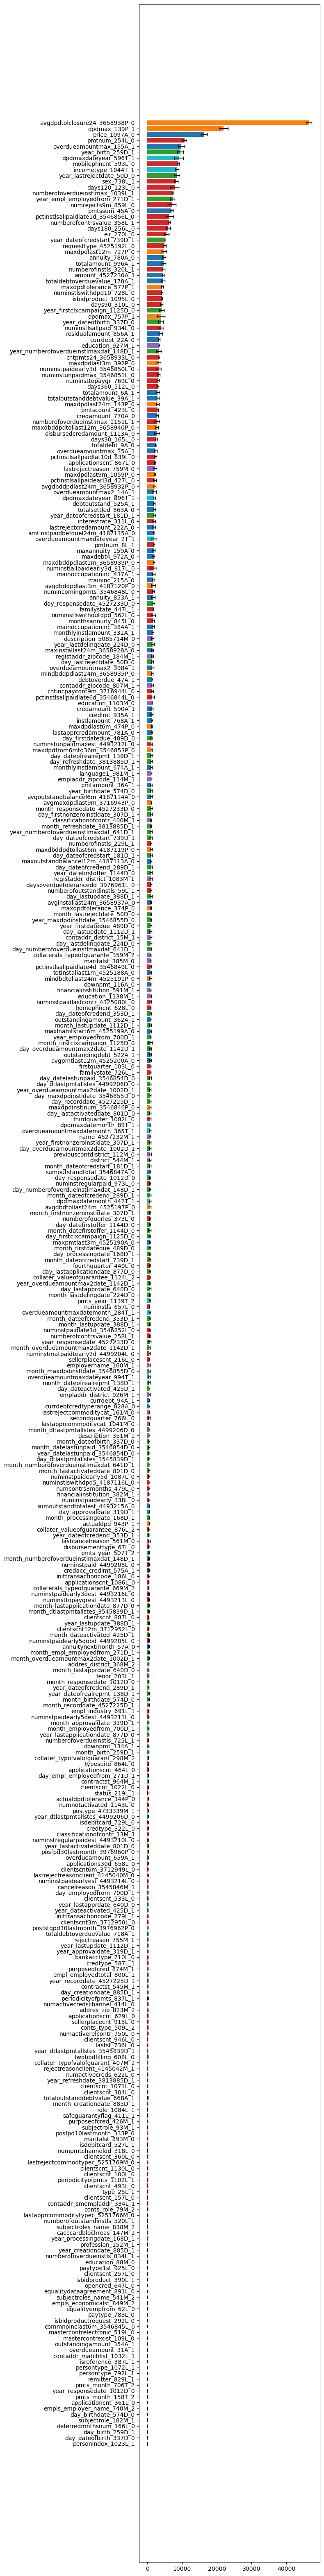

In [12]:
colors = np.array(['tab:orange'] * len(fimps))
colors[fimps['transform']=='A'] = 'tab:blue'
colors[fimps['transform']=='D'] = 'tab:green'
colors[fimps['transform']=='L'] = 'tab:red'
colors[fimps['transform']=='M'] = 'tab:purple'
colors[fimps['transform']=='T'] = 'tab:cyan'

_, ax = plt.subplots(figsize=(8, 16*len(fimps)//100))
ax.barh(
    y=fimps['processed_Variable'],
    width=fimps['fimp_mean'],
    xerr=fimps['fimp_std'],
    capsize=3,
    color=colors,
)
plt.tight_layout()
#plt.xscale('log')
plt.show()

#### plot feature importance per depth

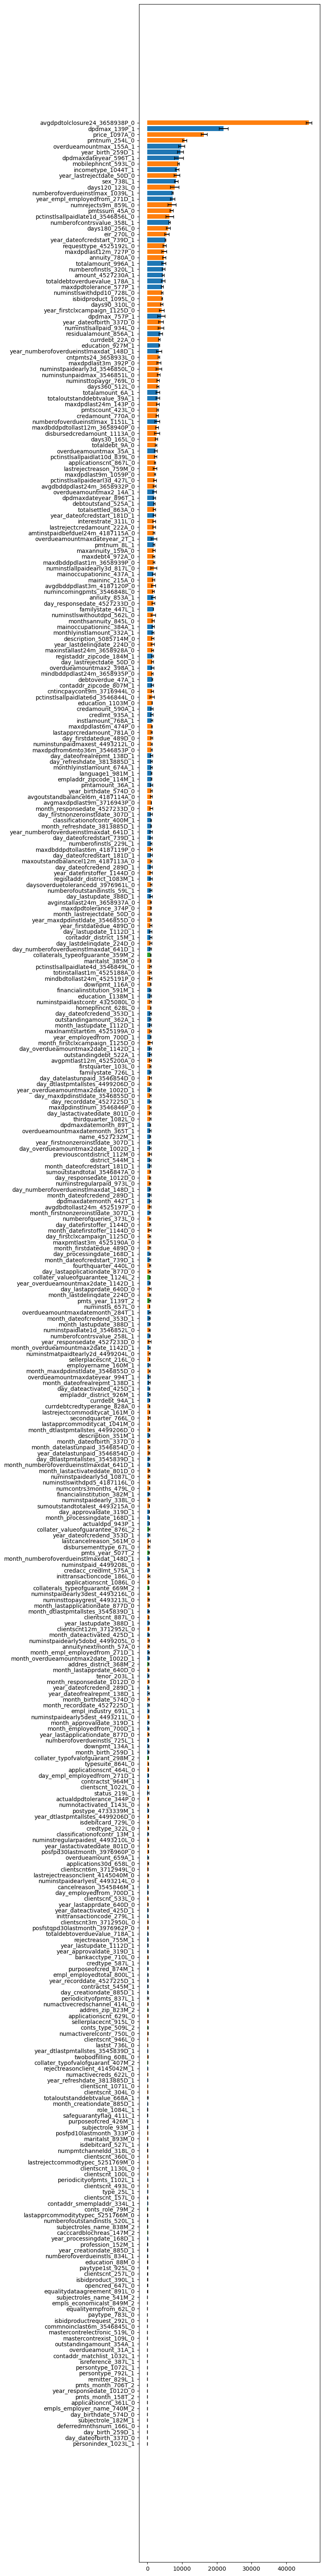

In [13]:
colors = np.array(['tab:orange'] * len(fimps))
colors[fimps['processed_Variable'].str.endswith('1')] = 'tab:blue'
colors[fimps['processed_Variable'].str.endswith('2')] = 'tab:green'

_, ax = plt.subplots(figsize=(8, 16*len(fimps)//100))
ax.barh(
    y=fimps['processed_Variable'],
    width=fimps['fimp_mean'],
    xerr=fimps['fimp_std'],
    capsize=3,
    color=colors,
)
plt.tight_layout()
#plt.xscale('log')
plt.show()

#### plot feature importance per number of nan

processed_Variable   fold_1_fimp   fold_2_fimp   fold_3_fimp  \
0              personindex_1023L_1      0.000000      0.000000      0.000000   
1           day_dateofbirth_337D_0      0.000000      0.000000      0.000000   
2                 day_birth_259D_1      0.000000      0.000000      0.000000   
3          deferredmnthsnum_166L_0      0.000000      0.000000      0.000000   
4               subjectrole_182M_1      0.000000      0.000000      0.000000   
..                             ...           ...           ...           ...   
392        overdueamountmax_155A_1   8044.246902  10278.366586   9874.608341   
393                  pmtnum_254L_0  10117.662024  11558.028876  10340.742229   
394                  price_1097A_0  15394.252024  17088.097522  15532.264152   
395                  dpdmax_139P_1  22780.665033  21494.436419  20901.952681   
396  avgdpdtolclosure24_3658938P_0  45509.695607  47670.802368  46138.021296   

      fold_4_fimp   fold_5_fimp     fimp_mean     fimp_std  \
0        0.000000      0.000000      0.000000     0.000000   
1        0.000000      0.000000      0.000000     0.000000   
2        0.000000      0.000000      0.000000     0.000000   
3        0.000000      0.000000      0.000000     0.000000   
4        0.000000      0.000000      0.000000     0.000000   
..            ...           ...           ...          ...   
392  10244.084540  10633.373105   9814.935895   917.352314   
393  10309.903605  11183.849430  10702.037233   564.032257   
394  17504.548259  15918.031022  16287.438596   851.697516   
395  24021.323479  20553.906897  21950.456902  1283.386272   
396  47189.168666  45984.896168  46498.516821   802.842945   

                        Variable  \
0              personindex_1023L   
1               dateofbirth_337D   
2                     birth_259D   
3          deferredmnthsnum_166L   
4               subjectrole_182M   
..                           ...   
392        overdueamountmax_155A   
393                  pmtnum_254L   
394                  price_1097A   
395                  dpdmax_139P   
396  avgdpdtolclosure24_3658938P   

                                                                                                                                                                                                               Description  \
0                                                                                                                                                                   Order of the person specified on the application form.   
1                                                                                                                                                                                                  Client's date of birth.   
2                                                                                                                                                                                             Date of birth of the person.   
3                                                                                                                                                                                               Number of deferred months.   
4                                                                                                                                                                                  Subject role in active credit contract.   
..                                                                                                                                                                                                                     ...   
392                                                                                                                                                                           Maximal past due amount for active contract.   
393                                                                                                  

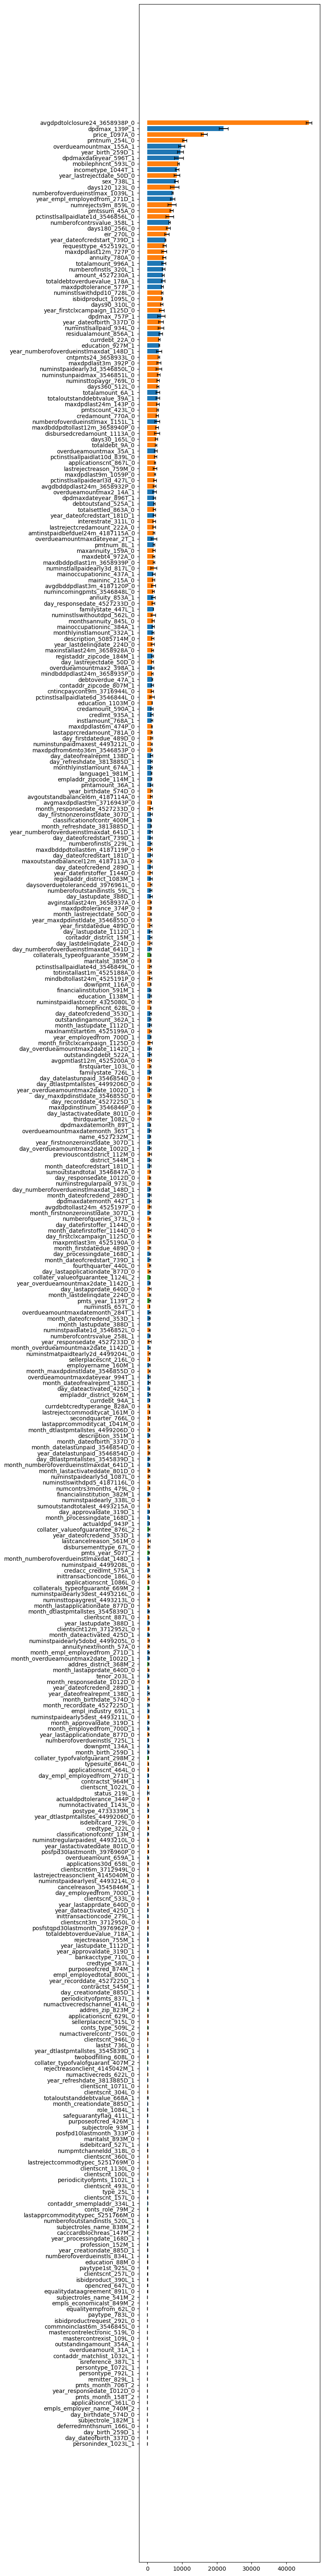

In [14]:
display(fimps)

colors = np.array(['tab:orange'] * len(fimps))
colors[fimps['processed_Variable'].str.endswith('1')] = 'tab:blue'
colors[fimps['processed_Variable'].str.endswith('2')] = 'tab:green'

_, ax = plt.subplots(figsize=(8, 16*len(fimps)//100))
ax.barh(
    y=fimps['processed_Variable'],
    width=fimps['fimp_mean'],
    xerr=fimps['fimp_std'],
    capsize=3,
    color=colors,
)
plt.tight_layout()
#plt.xscale('log')
plt.show()

#### plot feature importance per number of nan

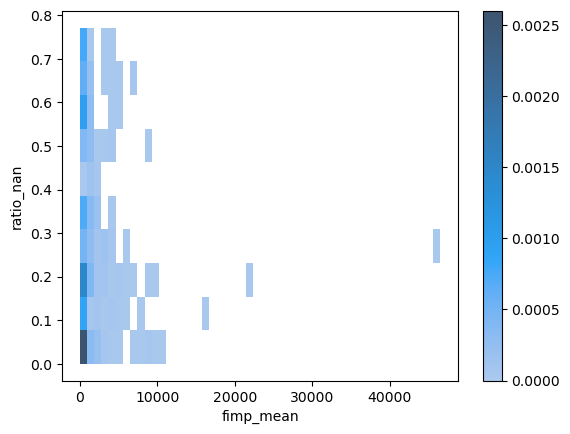

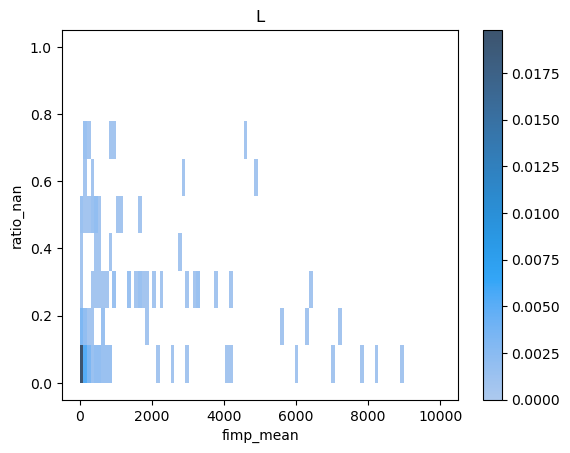

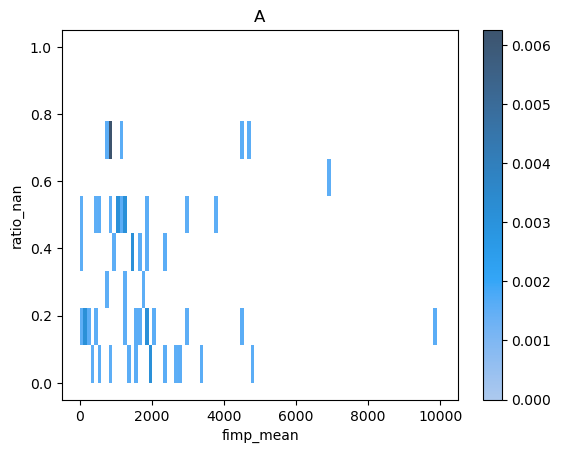

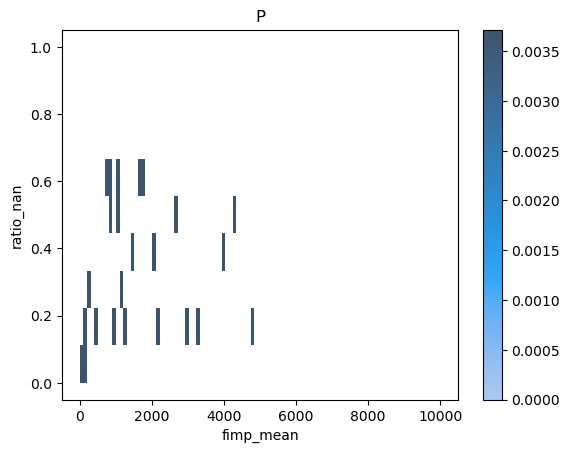

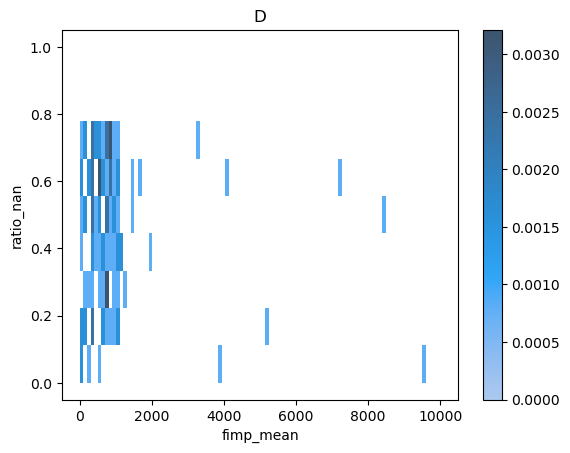

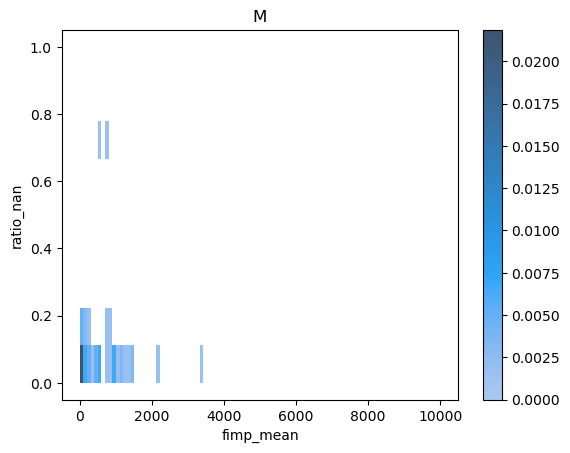

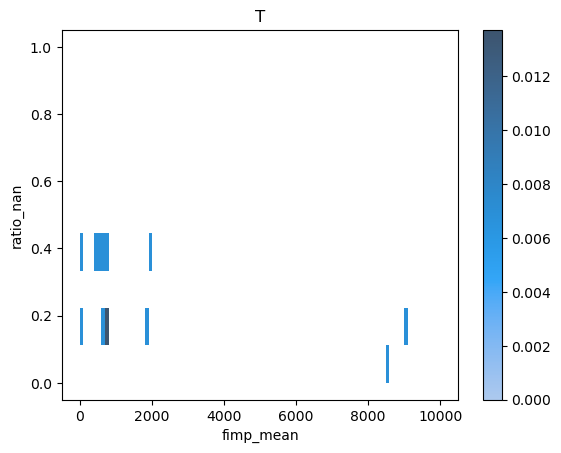

In [15]:
sns.histplot(
    data=fimps,
    x='fimp_mean',
    y='ratio_nan',
    bins=(50, 10),
    stat='density',
    cbar=True,
)
plt.show()


for t in ['L', 'A', 'P', 'D', 'M', 'T']:
    ax = sns.histplot(
        data=fimps.query('transform==@t'),
        x='fimp_mean',
        y='ratio_nan',
        bins=(np.linspace(0, 10000, 100), np.linspace(0, 1, 10)),
        stat='density',
        cbar=True,
    )
    ax.set_title(t)
    plt.show()

#### plot M features

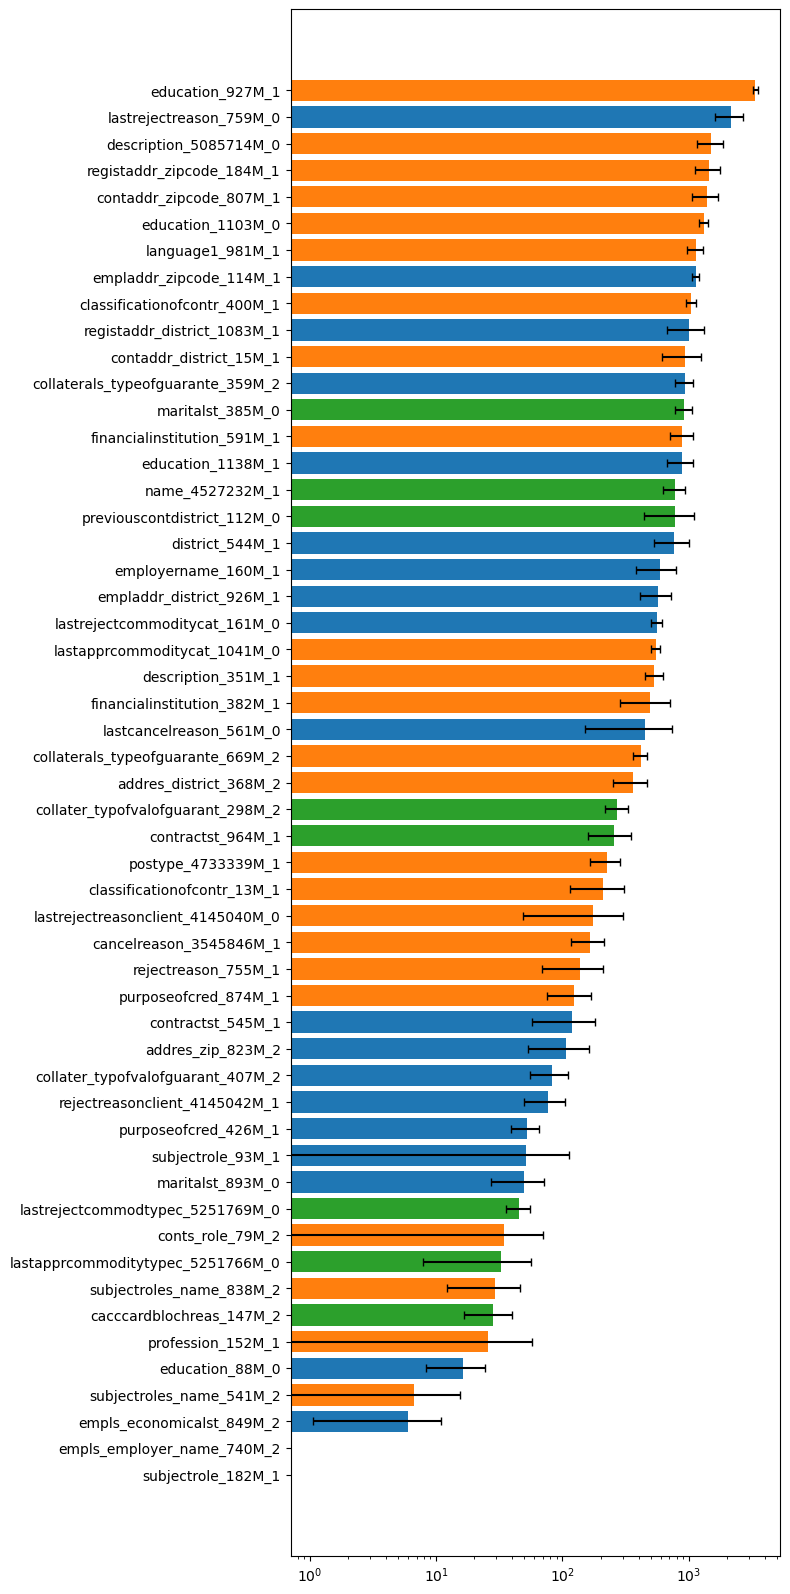

In [16]:
colors = np.array(['tab:orange'] * len(fimps))
colors[fimps['processed_Variable'].str.endswith('1')] = 'tab:blue'
colors[fimps['processed_Variable'].str.endswith('2')] = 'tab:green'

_, ax = plt.subplots(figsize=(8, 16))
ax.barh(
    y=fimps.query('transform=="M"')['processed_Variable'],
    width=fimps.query('transform=="M"')['fimp_mean'],
    xerr=fimps.query('transform=="M"')['fimp_std'],
    capsize=3,
    color=colors,
)
plt.tight_layout()
plt.xscale('log')
plt.show()

In [17]:
display(fimps.query('transform=="M"'))

processed_Variable  fold_1_fimp  fold_2_fimp  fold_3_fimp  \
4                   subjectrole_182M_1     0.000000     0.000000     0.000000   
6           empls_employer_name_740M_2     0.000000     0.000000     0.000000   
24           empls_economicalst_849M_2     0.000000     9.512860    11.035200   
25            subjectroles_name_541M_2     0.000000    21.312901    11.913700   
31                     education_88M_0    27.343700     7.701030    24.266540   
34                   profession_152M_1     9.582350    86.600498     0.000000   
36            cacccardblochreas_147M_2    11.739400    43.650400    29.003300   
37            subjectroles_name_838M_2    41.923470    54.364959    10.832250   
39   lastapprcommoditytypec_5251766M_0     0.000000    73.334860    34.266249   
40                    conts_role_79M_2    14.393200     5.438360    27.211341   
48    lastrejectcommodtypec_5251769M_0    36.279030    47.100490    50.251400   
52                    maritalst_893M_0    11.199400    37.462230    70.964699   
54                   subjectrole_93M_1     0.000000   155.641998    90.386698   
55                purposeofcred_426M_1    46.085060    35.364700    75.994599   
64       rejectreasonclient_4145042M_1    78.708098    73.067910    35.683091   
65   collater_typofvalofguarant_407M_2    70.952509   123.805201    50.814900   
74                   addres_zip_823M_2    45.323630   132.349420   102.480897   
78                   contractst_545M_1   160.271499    59.289839   214.149797   
81                purposeofcred_874M_1   112.474930   148.774509    41.153100   
86                 rejectreason_755M_1   113.053782    76.843719    92.057399   
95             cancelreason_3545846M_1    99.349132   247.740742   155.975680   
97   lastrejectreasonclient_4145040M_0   136.480300    68.636501   108.147119   
104        classificationofcontr_13M_1   217.814518   328.409531    71.463270   
108                 postype_4733339M_1   222.298601   258.248500   113.601200   
113                  contractst_964M_1   211.538718   356.058192   145.554541   
117  collater_typofvalofguarant_298M_2   188.325191   320.454295   321.144409   
133             addres_district_368M_2   307.221403   280.689558   373.537819   
146  collaterals_typeofguarante_669M_2   444.608199   338.967192   501.720703   
154            lastcancelreason_561M_0   142.099199   890.072543   694.623624   
162        financialinstitution_382M_1   403.053111   622.976790   252.457660   
172                 description_351M_1   618.028200   550.364408   495.615362   
174       lastapprcommoditycat_1041M_0   592.103163   559.621902   494.729692   
176      lastrejectcommoditycat_161M_0   507.939644   638.052887   521.585707   
179           empladdr_district_926M_1   749.693677   578.676879   325.973800   
184                employername_160M_1   433.708903   769.053338   314.896338   
219                    district_544M_1   545.353951   972.570691   463.490775   
220        previouscontdistrict_112M_0   465.530210  1357.950124   498.396781   
223                    name_4527232M_1   674.385261   896.237413   611.548369   
247                  education_1138M_1   723.403798  1118.598137   595.011957   
248        financialinstitution_591M_1   717.891486   961.484560   632.871159   
253                   maritalst_385M_0  1061.272970  1105.817387   712.427230   
254  collaterals_typeofguarante_359M_2   789.227386   853.597943   776.868124   
257            contaddr_district_15M_1   651.915521  1394.333228   533.033840   
267        registaddr_district_1083M_1   715.028502  1140.211334   616.870739   
277       classificationofcontr_400M_1   982.128818  1122.951407   980.893256   
284            empladdr_zipcode_114M_1  1122.036610  1129.361309   993.084020   
285                   language1_981M_1  1083.347764  1275.370285   855.245493   
297                  education_1103M_0  1394.742865  1360.378911  1107.504096   
300            contaddr_zipcode_807M_1  1220.793569

#### plot top k features

processed_Variable                         Variable  \
0            avgdpdtolclosure24_3658938P_0      avgdpdtolclosure24_3658938P   
1                            dpdmax_139P_1                      dpdmax_139P   
2                            price_1097A_0                      price_1097A   
3                            pmtnum_254L_0                      pmtnum_254L   
4                  overdueamountmax_155A_1            overdueamountmax_155A   
5                        year_birth_259D_1                       birth_259D   
6                    dpdmaxdateyear_596T_1              dpdmaxdateyear_596T   
7                      mobilephncnt_593L_0                mobilephncnt_593L   
8                       incometype_1044T_1                 incometype_1044T   
9                year_lastrejectdate_50D_0               lastrejectdate_50D   
10                              sex_738L_1                         sex_738L   
11                          days120_123L_0                     days120_123L   
12         numberofoverdueinstlmax_1039L_1    numberofoverdueinstlmax_1039L   
13           year_empl_employedfrom_271D_1           empl_employedfrom_271D   
14                     numrejects9m_859L_0                numrejects9m_859L   
15                           pmtssum_45A_0                      pmtssum_45A   
16       pctinstlsallpaidlate1d_3546856L_0  pctinstlsallpaidlate1d_3546856L   
17              numberofcontrsvalue_358L_1         numberofcontrsvalue_358L   
18                          days180_256L_0                     days180_256L   
19                              eir_270L_0                         eir_270L   
20             year_dateofcredstart_739D_1             dateofcredstart_739D   
21                  requesttype_4525192L_0             requesttype_4525192L   
22                    maxdpdlast12m_727P_0               maxdpdlast12m_727P   
23                          annuity_780A_0                     annuity_780A   
24                      totalamount_996A_1                 totalamount_996A   
25                   numberofinstls_320L_1              numberofinstls_320L   
26                       amount_4527230A_1                  amount_4527230A   
27            totaldebtoverduevalue_178A_1       totaldebtoverduevalue_178A   
28                  maxdpdtolerance_577P_1             maxdpdtolerance_577P   
29               numinstlswithdpd10_728L_0          numinstlswithdpd10_728L   
30                    isbidproduct_1095L_0               isbidproduct_1095L   
31                           days90_310L_0                      days90_310L   
32           year_firstclxcampaign_1125D_0           firstclxcampaign_1125D   
33                           dpdmax_757P_1                      dpdmax_757P   
34                 year_dateofbirth_337D_0                 dateofbirth_337D   
35                 numinstlsallpaid_934L_0            numinstlsallpaid_934L   
36                   residualamount_856A_1              residualamount_856A   
37                          currdebt_22A_0                     currdebt_22A   
38                        education_927M_1                   education_927M   
39  year_numberofoverdueinstlmaxdat_148D_1  numberofoverdueinstlmaxdat_148D   
40                    cntpmts24_3658933L_0               cntpmts24_3658933L   
41                     maxdpdlast3m_392P_0                maxdpdlast3m_392P   
42           numinstpaidearly3d_3546850L_0      numinstpaidearly3d_3546850L   
43             numinstunpaidmax_3546851L_0        numinstunpaidmax_3546851L   
44                   numinsttopaygr_769L_0              numinsttopaygr_769L   
45                          days360_512L_0                     days360_512L   
46                        totalamount_6A_1                   totalamount_6A   
47            totaloutstanddebtvalue_39A_1       totaloutstanddebtvalue_39A   
48                    maxdpdlast24m_143P_0               maxdpdlast24m_143P   
49                        pmtscount_423L_0                   pmtscount_423

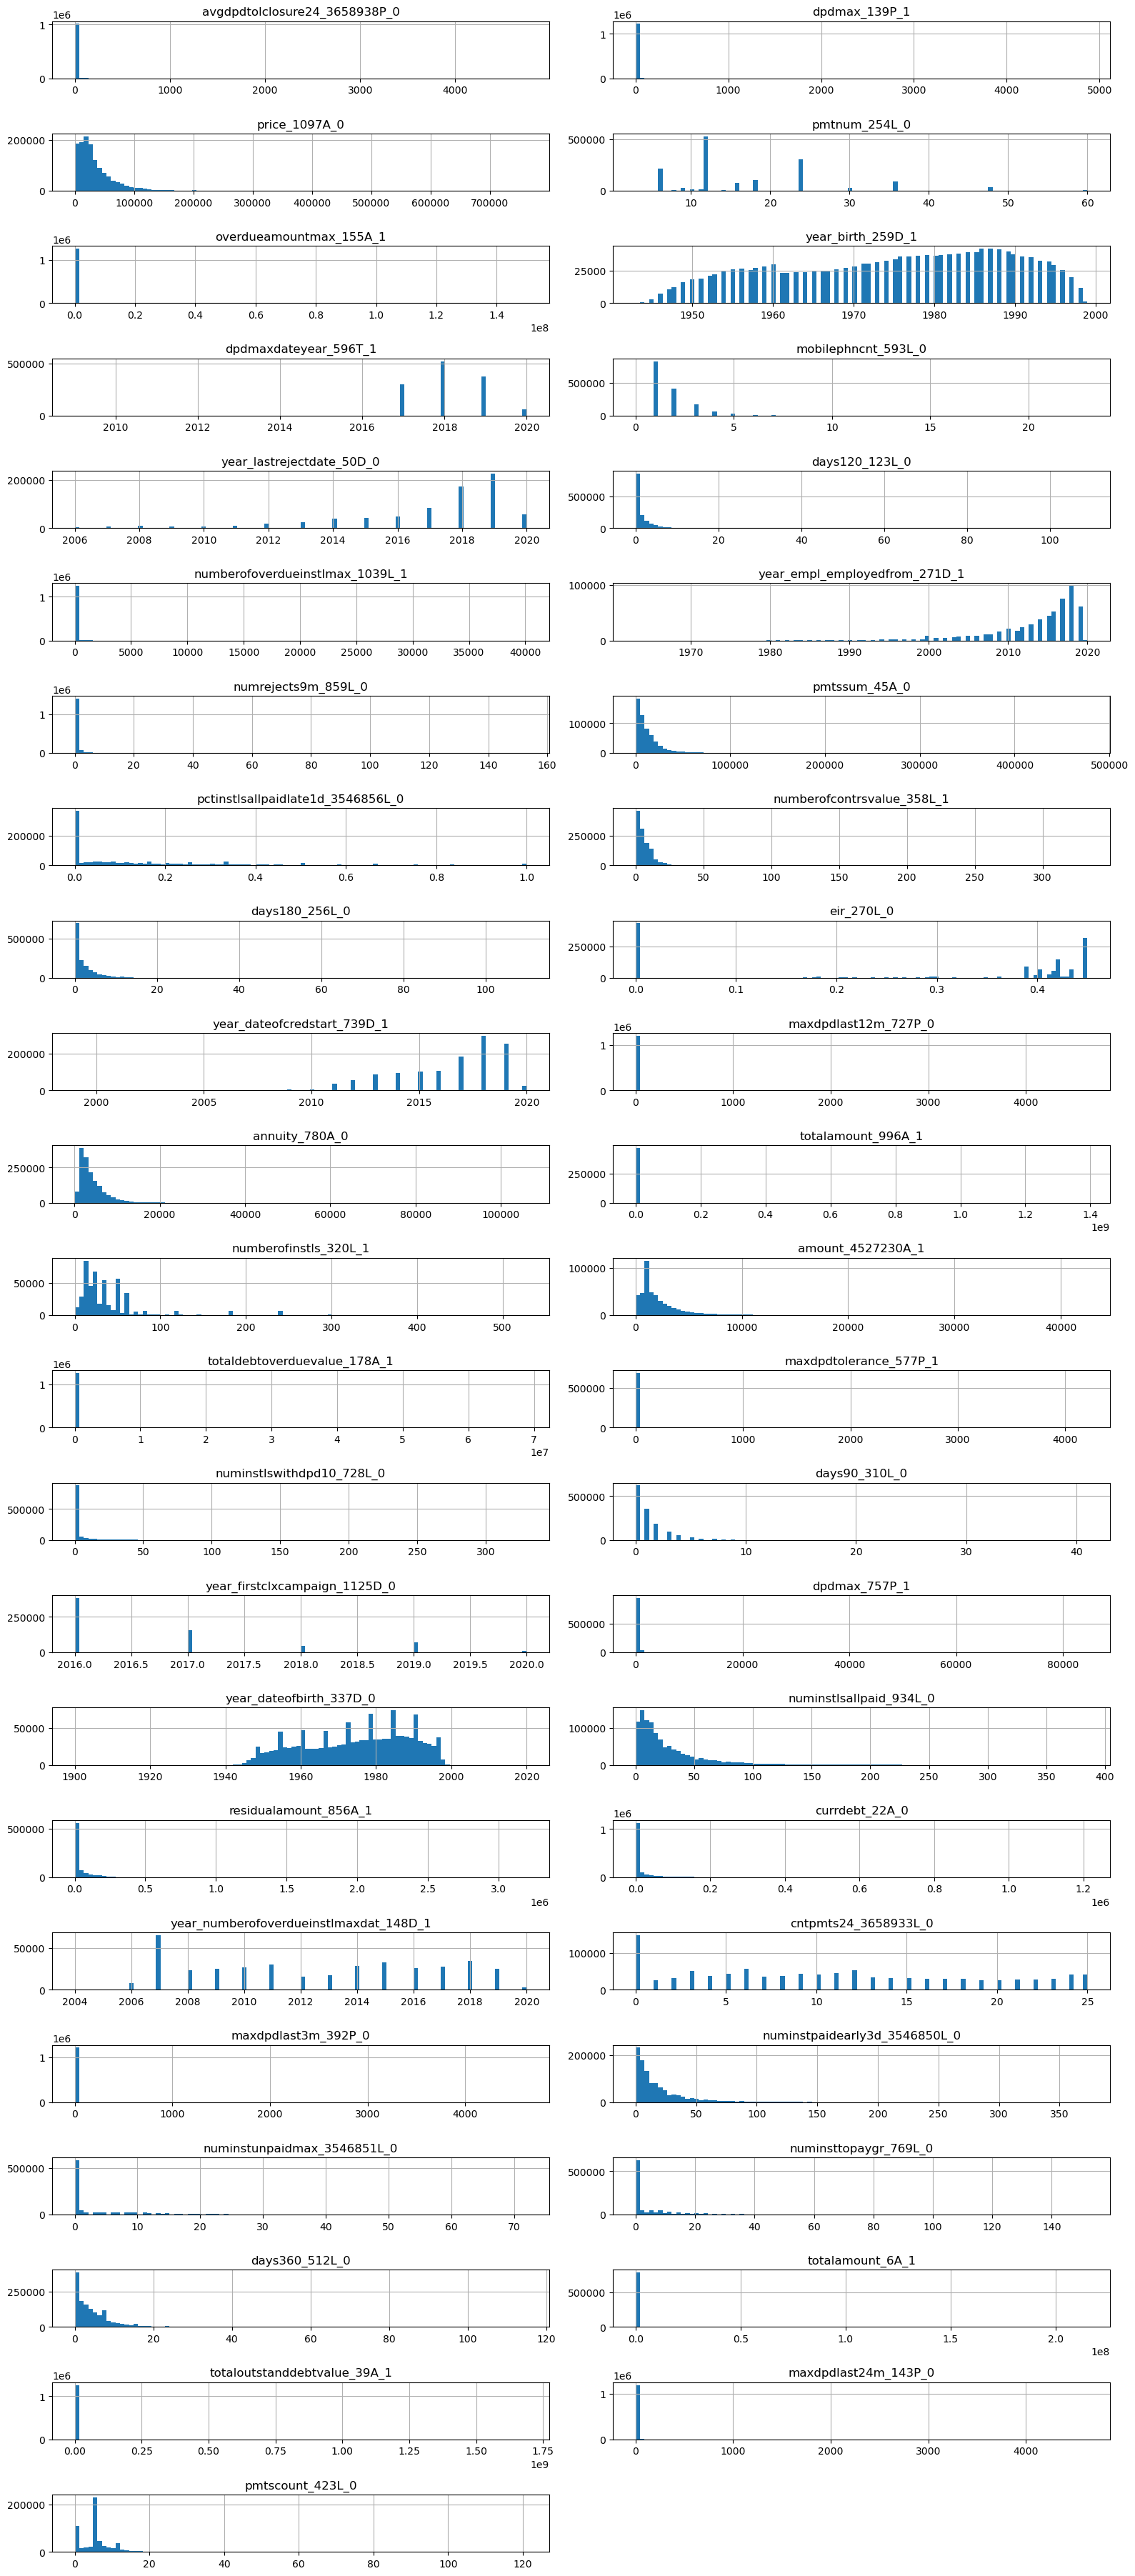

In [18]:
k = 50
topk_features = fimps.sort_values('fimp_mean', ascending=False).reset_index(drop=True).iloc[:50]
display(topk_features[['processed_Variable', 'Variable', 'Description', 'transform']])

_ = depth_data[topk_features['processed_Variable'].to_list()].hist(bins=100, layout=(len(topk_features)+1, 2), figsize=(16, 16*5))
plt.tight_layout()
plt.show()

### investigate avgdpdtolclosure24_3658938P

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
          ... 
1526654    0.0
1526655    0.0
1526656    1.0
1526657    0.0
1526658    0.0
Name: avgdpdtolclosure24_3658938P_0, Length: 1526659, dtype: float32

467175

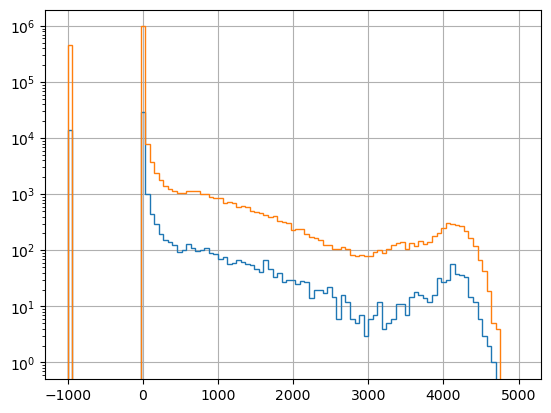

In [19]:
display(depth_data['avgdpdtolclosure24_3658938P_0'])
display(depth_data['avgdpdtolclosure24_3658938P_0'].isna().sum())

_, ax = plt.subplots()
bins = np.linspace(-1000, 5000, 100)
depth_data.query('target==1')['avgdpdtolclosure24_3658938P_0'].fillna(-999).hist(ax=ax, histtype='step', bins=bins)
depth_data.query('target==0')['avgdpdtolclosure24_3658938P_0'].fillna(-999).hist(ax=ax, histtype='step', bins=bins)
plt.yscale('log')
plt.show()

### plot probability per week

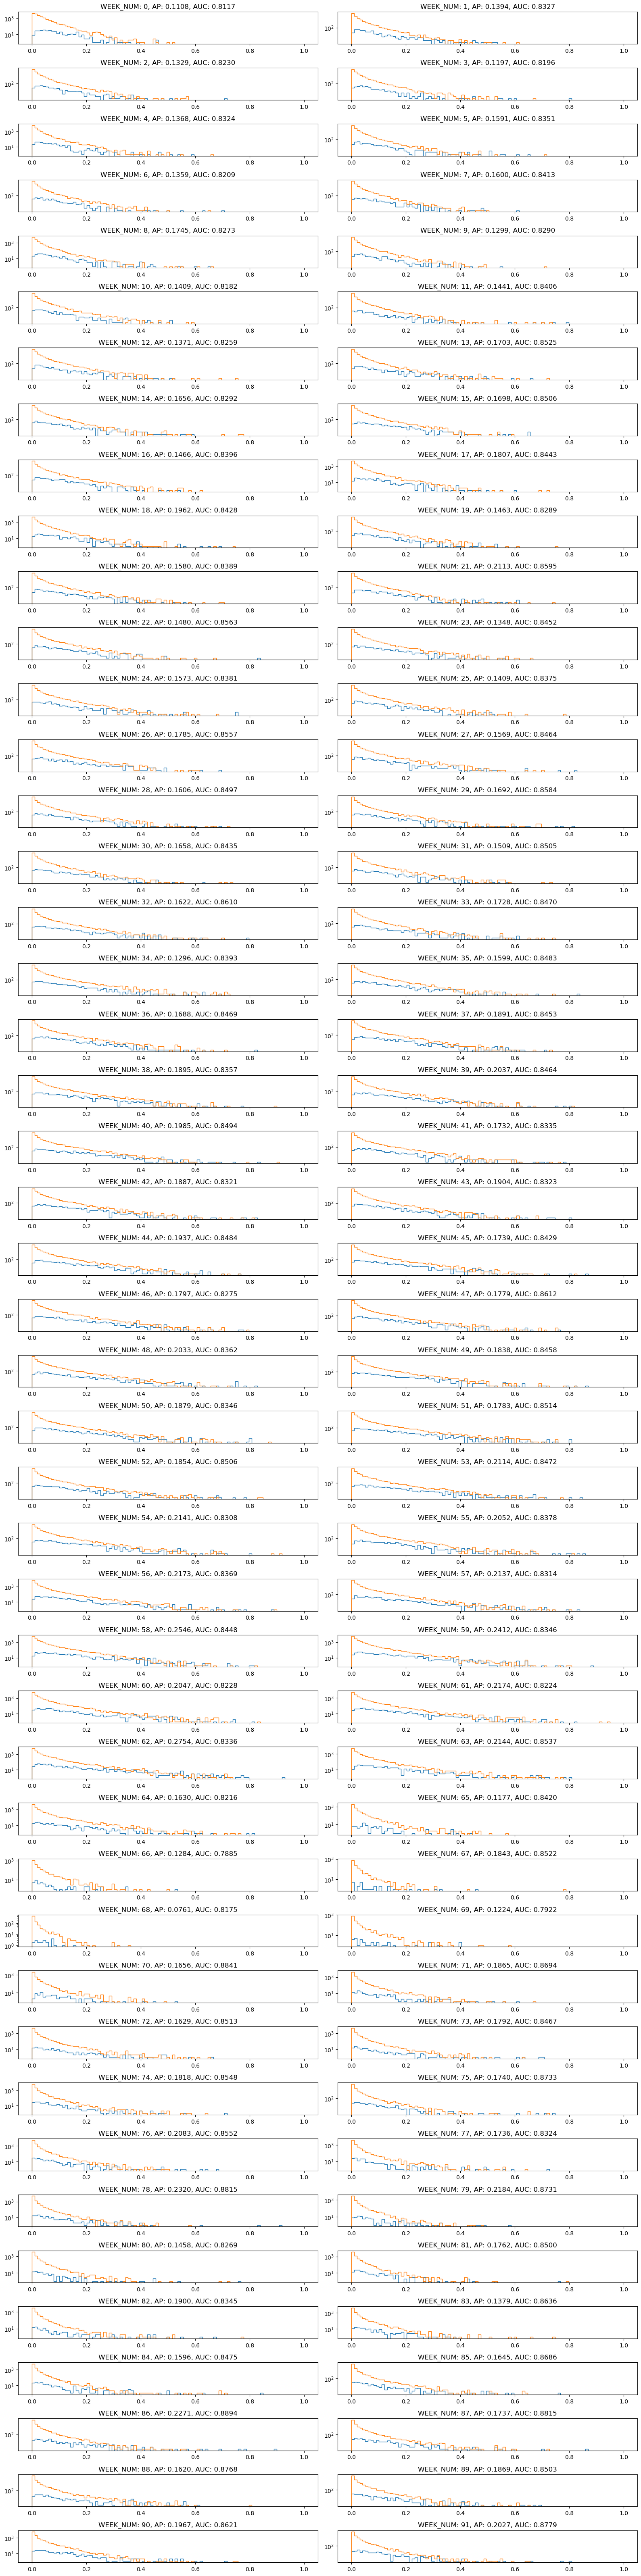

In [20]:
def plot_probability(oof):
    _, axs = plt.subplots(92//2, 2, figsize=(16, 64))
    bins = np.linspace(0, 1, 100)
    for i, (_, g) in enumerate(oof.groupby('WEEK_NUM')[['probability', 'target']]):
        ap = average_precision_score(g['target'], g['probability'])
        auc = roc_auc_score(g['target'], g['probability'])
        axs[i//2, i%2].hist(g.query('target==1')['probability'], bins=bins, histtype='step')
        axs[i//2, i%2].hist(g.query('target==0')['probability'], bins=bins, histtype='step')
        axs[i//2, i%2].set_yscale('log')
        axs[i//2, i%2].set_title(f'WEEK_NUM: {i}, AP: {ap:.4f}, AUC: {auc:.4f}')
    plt.tight_layout()
    plt.show()


plot_probability(oof)

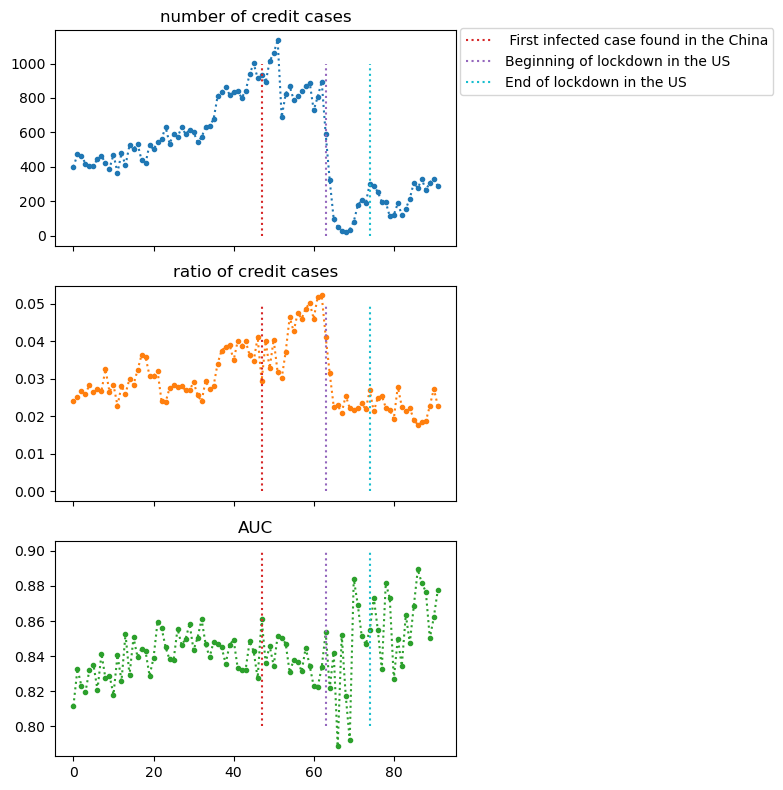

In [21]:
num_target_per_week = oof.groupby('WEEK_NUM')['target'].sum()
ratio_target_per_week = oof.groupby('WEEK_NUM')['target'].agg(lambda x: x.sum() / len(x))
auc_per_week = oof.groupby('WEEK_NUM')[['probability', 'target']].apply(lambda x: roc_auc_score(x['target'], x['probability']))

_, axs = plt.subplots(3, 1, figsize=(8, 8), sharex=True)
axs[0].plot(num_target_per_week, marker='.', linestyle=':')
axs[1].plot(ratio_target_per_week, marker='.', linestyle=':', color='tab:orange')
axs[2].plot(auc_per_week, marker='.', linestyle=':', color='tab:green')
axs[0].set_title('number of credit cases')
axs[1].set_title('ratio of credit cases')
axs[2].set_title('AUC')

axs[0].vlines(47, 0, 1000, color='tab:red', linestyle=':', label=' First infected case found in the China')
axs[1].vlines(47, 0, 0.05, color='tab:red', linestyle=':')
axs[2].vlines(47, 0.8, 0.9, color='tab:red', linestyle=':')

axs[0].vlines(63, 0, 1000, color='tab:purple', linestyle=':', label='Beginning of lockdown in the US')
axs[1].vlines(63, 0, 0.05, color='tab:purple', linestyle=':')
axs[2].vlines(63, 0.8, 0.9, color='tab:purple', linestyle=':')

axs[0].vlines(74, 0, 1000, color='tab:cyan', linestyle=':', label='End of lockdown in the US')
axs[1].vlines(74, 0, 0.05, color='tab:cyan', linestyle=':')
axs[2].vlines(74, 0.8, 0.9, color='tab:cyan', linestyle=':')
axs[0].legend(bbox_to_anchor=(1.01, 1.01), borderaxespad=0)

plt.tight_layout()
plt.show()

### about covid-19

In [22]:
display(oof)
display(oof.query('MONTH==201912').sort_values('MONTH'))
display(oof.query('MONTH==202006').sort_values('MONTH'))

case_id date_decision   MONTH  WEEK_NUM  target  probability  fold
0              0    2019-01-03  201901         0       0     0.042233   0.0
1              1    2019-01-03  201901         0       0     0.056855   0.0
2              2    2019-01-04  201901         0       0     0.064954   0.0
3              3    2019-01-03  201901         0       0     0.081043   0.0
4              4    2019-01-04  201901         0       1     0.057548   0.0
...          ...           ...     ...       ...     ...          ...   ...
1526654  2703450    2020-10-05  202010        91       0     0.002438   0.0
1526655  2703451    2020-10-05  202010        91       0     0.004591   0.0
1526656  2703452    2020-10-05  202010        91       0     0.031286   0.0
1526657  2703453    2020-10-05  202010        91       0     0.002985   0.0
1526658  2703454    2020-10-05  202010        91       0     0.002778   0.0

[1526659 rows x 7 columns]

case_id date_decision   MONTH  WEEK_NUM  target  probability  fold
38925      38925    2019-12-02  201912        47       0     0.413779   0.0
1100750  1694779    2019-12-17  201912        50       0     0.012504   3.0
1100749  1694778    2019-12-17  201912        50       0     0.002607   3.0
1100748  1694777    2019-12-17  201912        50       0     0.007098   3.0
1100747  1694776    2019-12-17  201912        50       0     0.042495   3.0
...          ...           ...     ...       ...     ...          ...   ...
528471    913004    2019-12-27  201912        51       0     0.043546   2.0
528470    913003    2019-12-27  201912        51       0     0.010498   2.0
528469    913002    2019-12-27  201912        51       0     0.012712   2.0
528467    913000    2019-12-27  201912        51       0     0.022227   2.0
1479029  2655784    2019-12-31  201912        52       0     0.030929   1.0

[126011 rows x 7 columns]

case_id date_decision   MONTH  WEEK_NUM  target  probability  fold
51593      51593    2020-06-05  202006        74       0     0.041604   0.0
1267879  1861908    2020-06-13  202006        75       0     0.059064   0.0
1267880  1861909    2020-06-13  202006        75       0     0.001940   0.0
1267881  1861910    2020-06-13  202006        75       0     0.032045   0.0
1267882  1861911    2020-06-13  202006        75       0     0.056176   0.0
...          ...           ...     ...       ...     ...          ...   ...
608196    992729    2020-06-14  202006        75       0     0.006933   0.0
608197    992730    2020-06-14  202006        75       0     0.002656   0.0
608198    992731    2020-06-14  202006        75       0     0.008824   0.0
608178    992711    2020-06-14  202006        75       0     0.003942   0.0
1509550  2686305    2020-06-30  202006        78       0     0.017110   3.0

[45962 rows x 7 columns]